# Data Preparation

In [ ]:
# data for this assignment was found here: https://www.kaggle.com/cityofLA/los-angeles-311-call-center-tracking-data 

In [1]:
# import standard packages here
# non standard packages are imported closer to the code/functions that use them
import warnings
warnings.filterwarnings("ignore")
import gc # Garbage Collector
import keras.backend as K

# import data manipulation/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import datetime

# for model building and results
import tensorflow as tf
from keras import layers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Flatten, Dense, SimpleRNN, Dropout

# misc
import time
from prettytable import PrettyTable

# fix a random seed for reproducibility
RANDOM_SEED = 42
from numpy.random import seed
from tensorflow import set_random_seed
def reset_graph(seed = RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


In [2]:
# set working directory
import os
os.getcwd()

# set other file paths vars
data_path = '..\\data'
model_path = '..\\output\\models'

# set color palette
current_palette = sns.color_palette() #10 colors

In [3]:
# must download data from https://www.kaggle.com/cityofLA/los-angeles-311-call-center-tracking-data
# this takes a little bit
original_df = pd.read_csv(os.path.join(data_path,'311-call-center-tracking-data-archived.csv'))

In [3]:
original_df.head()
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565447 entries, 0 to 3565446
Data columns (total 7 columns):
Date                       object
Time                       object
Department Abbreviation    object
Department Name            object
Service Name               object
Call Resolution            object
Zip Code                   float64
dtypes: float64(1), object(6)
memory usage: 190.4+ MB


In [4]:
# need to correct data types
# for this reason, we create a new df so we can leave our original df untouched
new_df = original_df.copy()
new_df.info()
new_df.head()
# new_df['Department Abbreviation'].unique()
# new_df['Department Name'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565447 entries, 0 to 3565446
Data columns (total 7 columns):
Date                       object
Time                       object
Department Abbreviation    object
Department Name            object
Service Name               object
Call Resolution            object
Zip Code                   float64
dtypes: float64(1), object(6)
memory usage: 190.4+ MB


,Date,Time,Department Abbreviation,Department Name,Service Name,Call Resolution,Zip Code
0,2014-01-01T00:00:00,08:08:54,DOT,Department of Transportation,Parking Enforcement,Transfer (City),91605.0
1,2014-01-01T00:00:00,08:09:00,LAPD,Los Angeles Police Department,Police Stations (Front Desk / Public Counter -...,Gave Caller Information,90402.0
2,2014-01-01T00:00:00,08:09:34,DOT,Department of Transportation,Meter Request Service,Gave Caller Information,99999.0
3,2014-01-01T00:00:00,08:10:11,BOS,PW/Bureau of Sanitation,Replacement/Repair of Curbside Trash Containers,Gave Caller Information,90023.0
4,2014-01-01T00:00:00,08:11:01,BOS,PW/Bureau of Sanitation,Bulky Item Pick-up,Service Request Processed,90044.0


In [5]:
# how many training instances?
print(len(new_df))

3565447


In [6]:
# there are 61 departments - this makes summing by department more cumbersome
# unless want to spend ample time combining departments and whatnot
# think it makes sense to just sum by day
new_df['Department Abbreviation'].nunique()

61

In [7]:
new_df.isnull().sum()

Date                            1
Time                            0
Department Abbreviation    443434
Department Name            443434
Service Name               443434
Call Resolution             22882
Zip Code                    79822
dtype: int64

In [8]:
# change data types
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Department Abbreviation'] = new_df['Department Abbreviation'].astype(str)
new_df['Department Abbreviation'].fillna('Unknown', inplace=True)
new_df['Row Num'] = range(1, len(new_df.index)+1)

In [9]:
new_df.head(10)

,Date,Time,Department Abbreviation,Department Name,Service Name,Call Resolution,Zip Code,Row Num
0,2014-01-01,08:08:54,DOT,Department of Transportation,Parking Enforcement,Transfer (City),91605.0,1
1,2014-01-01,08:09:00,LAPD,Los Angeles Police Department,Police Stations (Front Desk / Public Counter -...,Gave Caller Information,90402.0,2
2,2014-01-01,08:09:34,DOT,Department of Transportation,Meter Request Service,Gave Caller Information,99999.0,3
3,2014-01-01,08:10:11,BOS,PW/Bureau of Sanitation,Replacement/Repair of Curbside Trash Containers,Gave Caller Information,90023.0,4
4,2014-01-01,08:11:01,BOS,PW/Bureau of Sanitation,Bulky Item Pick-up,Service Request Processed,90044.0,5
5,2014-01-01,08:11:07,BSS,PW/Bureau of Street Services,Maintenance of Public Street Landscape,Gave Caller Information,91605.0,6
6,2014-01-01,08:11:25,BPW,PW/Board of Public Works,Graffiti Removal - Community Beautification,Service Request Processed,90029.0,7
7,2014-01-01,08:12:23,BOS,PW/Bureau of Sanitation,Bulky Item Pick-up,Service Request Processed,90019.0,8
8,2014-01-01,08:12:36,LAPD,Los Angeles Police Department,877 ASK-LAPD - Non-emergency Police Service,Gave Caller Information,90004.0,9
9,2014-01-01,08:13:56,BSS,PW/Bureau of Street Services,Street Use Permits,Gave Caller Information,90042.0,10


In [10]:
# remove missing date row
new_df = new_df[new_df['Date'].notnull()]

In [11]:
# add hour variable - used later to create a summary df
# this takes some time
new_df['Hour'] = pd.to_datetime(new_df['Time'],format= '%H:%M:%S').apply(pd.Timestamp).apply(lambda x: x.hour)

In [12]:
# check that missing values were handled correctly
new_df.isnull().sum()

Date                            0
Time                            0
Department Abbreviation         0
Department Name            443434
Service Name               443434
Call Resolution             22882
Zip Code                    79821
Row Num                         0
Hour                            0
dtype: int64

In [13]:
# validate new data types
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3565446 entries, 0 to 3565446
Data columns (total 9 columns):
Date                       datetime64[ns]
Time                       object
Department Abbreviation    object
Department Name            object
Service Name               object
Call Resolution            object
Zip Code                   float64
Row Num                    int32
Hour                       int64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(5)
memory usage: 258.4+ MB


In [14]:
# aggregate our data by department by day
day_df = new_df.groupby(['Date'])['Row Num'].count()

# save to csv
day_df.to_csv('LA-311-calls-by-day.csv')

In [15]:
day_df.head(10)

Date
2011-01-01     948
2011-01-02     905
2011-01-03    3894
2011-01-04    3730
2011-01-05    3636
2011-01-06    2835
2011-01-07    4442
2011-01-08    1559
2011-01-09    1237
2011-01-10    4316
Name: Row Num, dtype: int64

In [16]:
# aggregate our data by department by day and hour
hour_df = new_df.groupby(['Date','Hour'])['Row Num'].count()

In [17]:
print(hour_df.head(20))
print(len(hour_df))

Date        Hour
2011-01-01  6         1
            7        19
            8        30
            9        56
            10       73
            11       78
            12       96
            13      114
            14       96
            15       84
            16       68
            17       62
            18       54
            19       50
            20       34
            21       33
2011-01-02  6         3
            7        42
            8        55
            9        75
Name: Row Num, dtype: int64
17295


In [18]:
# convert this grouped data frame (technically series) to a data frame
final_df = pd.DataFrame({'period':day_df.index, 'count':day_df.values})

# add some other cols for plotting
final_df['year_month'] = final_df['period'].map(lambda x: 100*x.year + x.month)
final_df['year'] = final_df['period'].map(lambda x: x.year)
final_df['month'] = final_df['period'].map(lambda x: x.month)
final_df['day'] = final_df['period'].map(lambda x: x.day)
final_df['day_of_week'] = final_df['period'].map(lambda x: x.weekday()) # monday = 0; sunday = 6

In [19]:
final_df.info()
final_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 7 columns):
period         1610 non-null datetime64[ns]
count          1610 non-null int64
year_month     1610 non-null int64
year           1610 non-null int64
month          1610 non-null int64
day            1610 non-null int64
day_of_week    1610 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 88.1 KB


,period,count,year_month,year,month,day,day_of_week
0,2011-01-01,948,201101,2011,1,1,5
1,2011-01-02,905,201101,2011,1,2,6
2,2011-01-03,3894,201101,2011,1,3,0
3,2011-01-04,3730,201101,2011,1,4,1
4,2011-01-05,3636,201101,2011,1,5,2


In [20]:
# make sure we know min/max dates
print('Min date: ', final_df['period'].min())
print('Max date: ', final_df['period'].max())

# and number of training instances
print('Number of rows: ', len(final_df))

# and 5-number summmary for calls
from numpy import percentile
print("Min: ", min(final_df['count']))
print("Quartiles: ", percentile(final_df['count'], [25, 50, 75]))
print("Max: ", max(final_df['count']))

Min date:  2011-01-01 00:00:00
Max date:  2015-05-31 00:00:00
Number of rows:  1610
Min:  122
Quartiles:  [ 828.25 2580.   3123.75]
Max:  5108


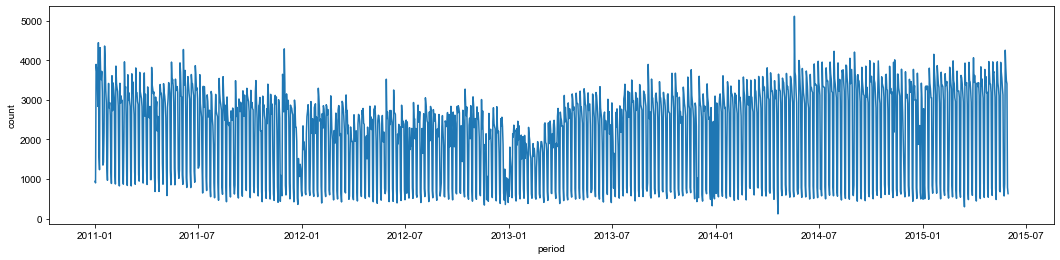

In [21]:
# let's examine the pattern by day
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (18,4))
sns.set(style="darkgrid")

sns.lineplot(x="period", y="count", data=final_df, palette=current_palette[0])

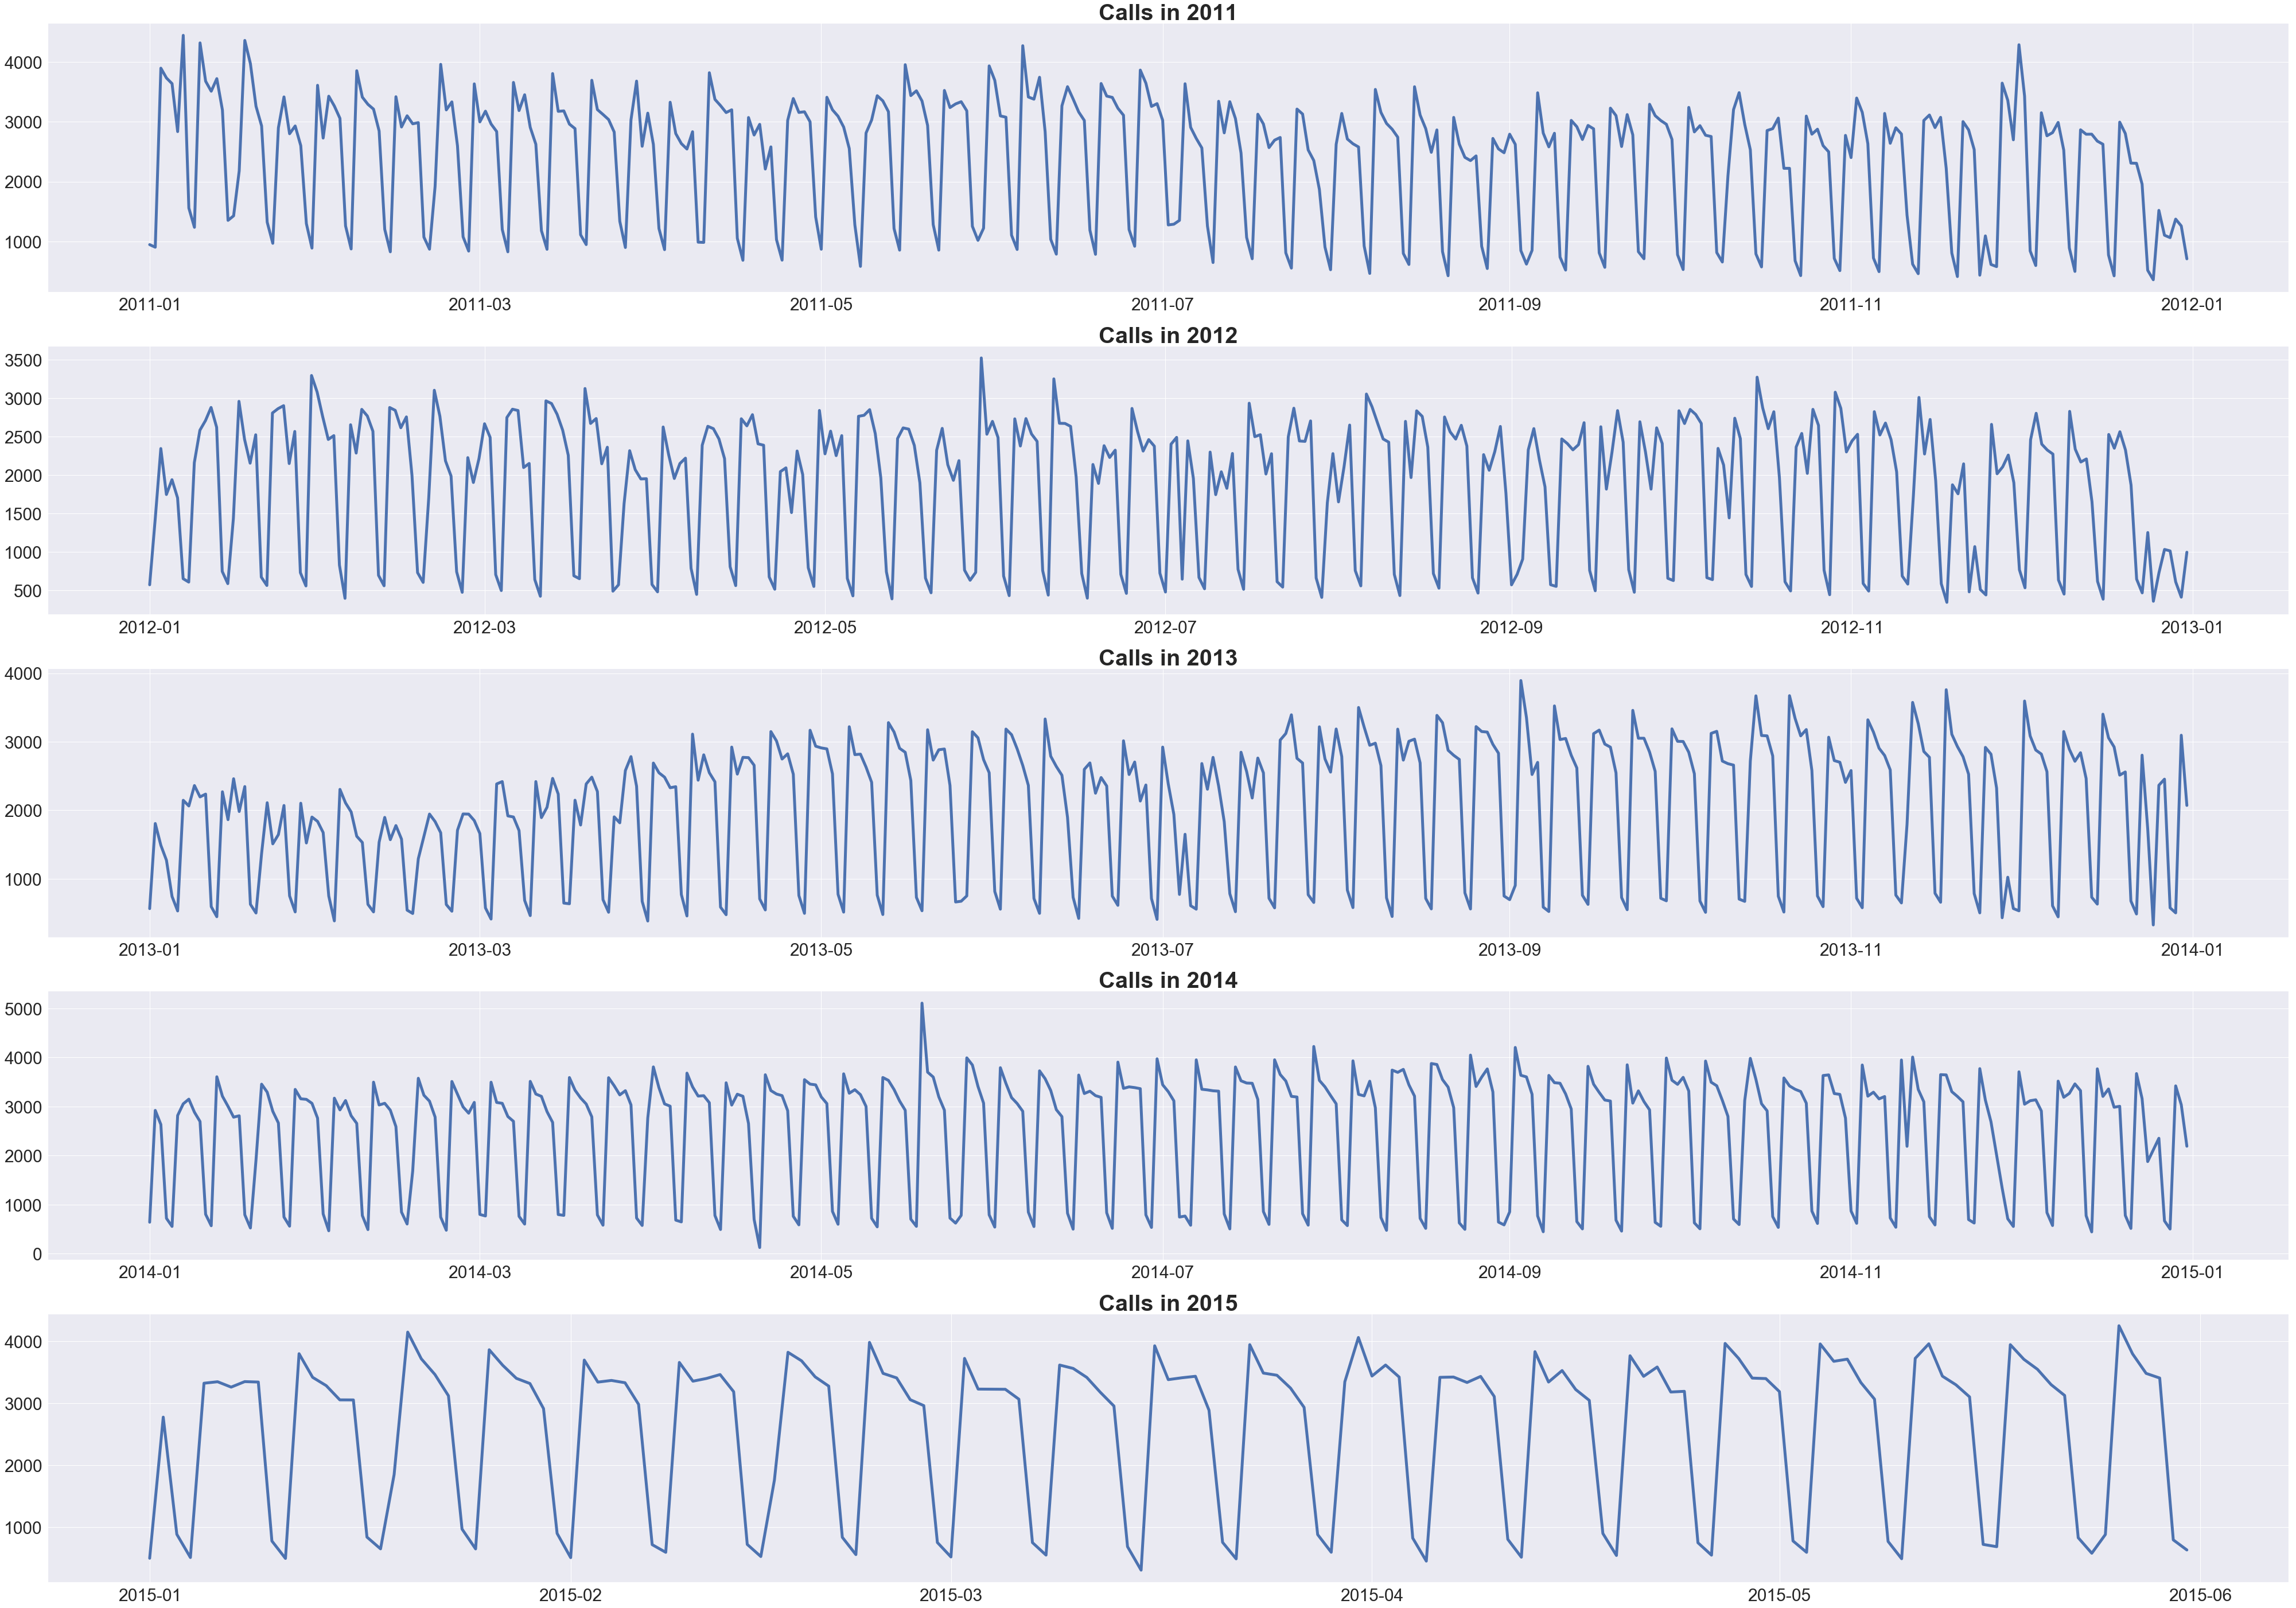

In [22]:
# let's break this up by year to more readily see what's happening
years_unique = final_df['year'].unique()
fig, axes = plt.subplots(figsize = (70,50))
sns.set(style="darkgrid")

for i in range(0,5):
    plt.subplot(5, 1, i + 1)
    sns.set_context(rc={"lines.linewidth": 5})
    ax = sns.lineplot(x="period", y="count", data=final_df[final_df['year']==years_unique[i]], palette=current_palette[0])
    plt.title('Calls in '+ str(years_unique[i]), size=40, fontweight="bold")
    plt.tick_params(labelsize=30)
    ax.yaxis.label.set_visible(False) # remove x and y labels
    ax.xaxis.label.set_visible(False)
    

Text(0.5, 1.0, 'Daily Seasonality')

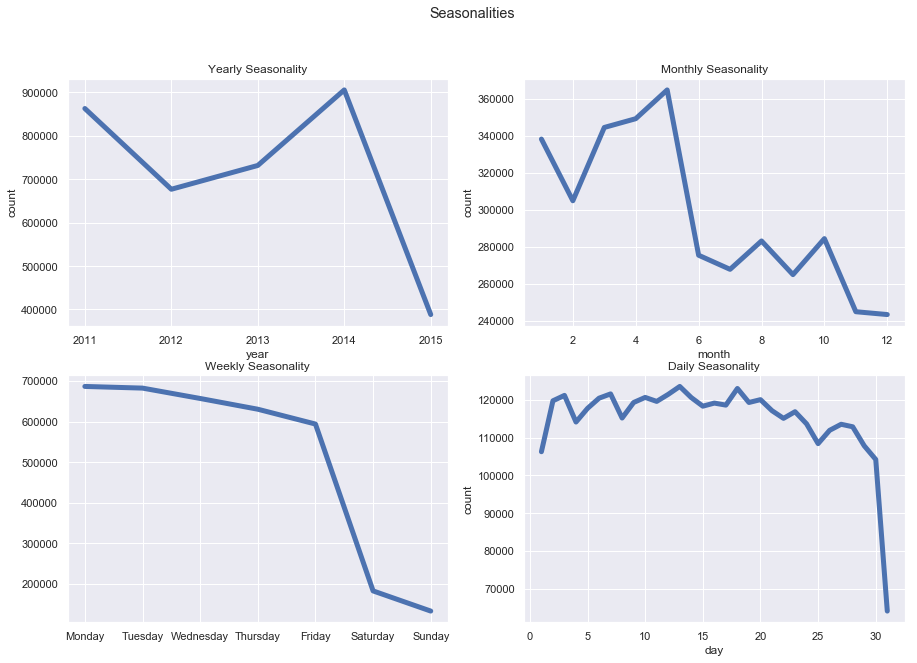

In [23]:
# let's summarize by year, day of week, and month to better see seasonalities
# summary df
year_sum = final_df.groupby('year')['count'].sum().to_frame('count').reset_index()
month_sum = final_df.groupby('month')['count'].sum().to_frame('count').reset_index()
within_month_sum = final_df.groupby('day')['count'].sum().to_frame('count').reset_index()

# extra work to map this b/c plot can't interpret 0 values
day_of_week_mapping = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
final_df['day_of_week_string'] = final_df['day_of_week'].map(day_of_week_mapping)
day_sum = final_df.groupby(['day_of_week','day_of_week_string'])['count'].sum().to_frame('count').reset_index().sort_values(by=['day_of_week'], ascending=True)
day_sum['day_of_week']=day_sum['day_of_week']+1

# plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.suptitle('Seasonalities')

ax1 = axes[0,0]
sns.lineplot(x="year", y="count", data=year_sum, palette=current_palette[0],ax=ax1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # funcformatter not working
ax1.set_title('Yearly Seasonality')

ax2 = axes[0,1]
sns.lineplot(x="month", y="count", data=month_sum, palette=current_palette[0],ax=ax2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax2.set_title('Monthly Seasonality')

ax3 = axes[1,0]
ax3.plot("day_of_week_string", "count", data=day_sum)
ax3.set_title('Weekly Seasonality')

ax4 = axes[1,1]
sns.lineplot(x="day", y="count", data=within_month_sum, palette=current_palette[0],ax=ax4)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax4.set_title('Daily Seasonality')


In [22]:
########### holiday analysis
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import get_calendar

cal = get_calendar('USFederalHolidayCalendar')
cal.rules

[Holiday: New Years Day (month=1, day=1, observance=<function nearest_workday at 0x0000016DB24B20D0>),
 Holiday: Dr. Martin Luther King Jr. (month=1, day=1, offset=<DateOffset: weekday=MO(+3)>),
 Holiday: Presidents Day (month=2, day=1, offset=<DateOffset: weekday=MO(+3)>),
 Holiday: MemorialDay (month=5, day=31, offset=<DateOffset: weekday=MO(-1)>),
 Holiday: July 4th (month=7, day=4, observance=<function nearest_workday at 0x0000016DB24B20D0>),
 Holiday: Labor Day (month=9, day=1, offset=<DateOffset: weekday=MO(+1)>),
 Holiday: Columbus Day (month=10, day=1, offset=<DateOffset: weekday=MO(+2)>),
 Holiday: Veterans Day (month=11, day=11, observance=<function nearest_workday at 0x0000016DB24B20D0>),
 Holiday: Thanksgiving (month=11, day=1, offset=<DateOffset: weekday=TH(+4)>),
 Holiday: Christmas (month=12, day=25, observance=<function nearest_workday at 0x0000016DB24B20D0>)]

In [23]:
cal = calendar()
holidays = cal.holidays(start=final_df['period'].min(), end=final_df['period'].max()) 
print(holidays)

# based on the rules for New Year's being nearest workday, 1/1/2011 doesn't appear 
# b/c Saturday can't be moved to Friday b/c that is a diff year. Changing min date doesn't resolve this.
# therefore, need to add a date - we will make sure 1/3/2011 is marked as a holiday as that follows in line with other new year's
dt = pd.to_datetime('2011-01-03')
holidays = holidays.insert(-1, dt)
print(holidays)

final_df['Holiday'] = final_df['period'].isin(holidays)

DatetimeIndex(['2011-01-17', '2011-02-21', '2011-05-30', '2011-07-04',
               '2011-09-05', '2011-10-10', '2011-11-11', '2011-11-24',
               '2011-12-26', '2012-01-02', '2012-01-16', '2012-02-20',
               '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-08',
               '2012-11-12', '2012-11-22', '2012-12-25', '2013-01-01',
               '2013-01-21', '2013-02-18', '2013-05-27', '2013-07-04',
               '2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2011-01-17', '2011-02-21', '2011-05-30', '2011-07-04',
               '2011-09-05', '2011-10-10', '2011-11-11', '2011-11-24',
               '2011-12-26', '2012-01-02'

In [24]:
final_df.head(20)

,period,count,year_month,year,month,day,day_of_week,Holiday
0,2011-01-01,948,201101,2011,1,1,5,False
1,2011-01-02,905,201101,2011,1,2,6,False
2,2011-01-03,3894,201101,2011,1,3,0,True
3,2011-01-04,3730,201101,2011,1,4,1,False
4,2011-01-05,3636,201101,2011,1,5,2,False
5,2011-01-06,2835,201101,2011,1,6,3,False
6,2011-01-07,4442,201101,2011,1,7,4,False
7,2011-01-08,1559,201101,2011,1,8,5,False
8,2011-01-09,1237,201101,2011,1,9,6,False
9,2011-01-10,4316,201101,2011,1,10,0,False


In [27]:
# convert holiday to 1/0 instead of True/False
final_df['Holiday'] = (final_df['Holiday'] == True).astype(int)
final_df.head(20)

,period,count,year_month,year,month,day,day_of_week,day_of_week_string,Holiday
0,2011-01-01,948,201101,2011,1,1,5,Saturday,0
1,2011-01-02,905,201101,2011,1,2,6,Sunday,0
2,2011-01-03,3894,201101,2011,1,3,0,Monday,1
3,2011-01-04,3730,201101,2011,1,4,1,Tuesday,0
4,2011-01-05,3636,201101,2011,1,5,2,Wednesday,0
5,2011-01-06,2835,201101,2011,1,6,3,Thursday,0
6,2011-01-07,4442,201101,2011,1,7,4,Friday,0
7,2011-01-08,1559,201101,2011,1,8,5,Saturday,0
8,2011-01-09,1237,201101,2011,1,9,6,Sunday,0
9,2011-01-10,4316,201101,2011,1,10,0,Monday,0


In [25]:
# convert to a numpy array
# we remove columns that aren't needed - just want period, count, and holiday
final_df2 = final_df[['count','Holiday']]
final_df2 = final_df2.as_matrix()
print(final_df2.shape)
#final_df2 = final_df2.reshape(1, len(final_df2), 2)
#print(final_df2.shape)
#print(final_df2[0][0])

(1610, 2)


In [26]:
# normalize the data
# use standardscaler b/c it is more robust against outliers
# cannot figure out how to not scale the holiday values - if pick off first val then get error expecting 2D array
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(final_df2[:1308])
final_df2 = scaler.transform(final_df2)
# to go back...scaler.inverse_transform(final_df2)

In [27]:
# quick check on data transformation
final_df2

array([[-1.11454402, -0.16581347],
       [-1.15482468, -0.16581347],
       [ 1.64514954,  6.03087295],
       ...,
       [ 1.18801089, -0.16581347],
       [-1.26255203, -0.16581347],
       [-1.41524383, -0.16581347]])

In [28]:
holiday_df = final_df[['Holiday']]
holiday_df = holiday_df.as_matrix()
final_df2 = np.concatenate((final_df2, holiday_df), axis=1)
final_df2 = final_df2[:,[0,2]] # remove the standardized holiday column
final_df2

array([[-1.11454402,  0.        ],
       [-1.15482468,  0.        ],
       [ 1.64514954,  1.        ],
       ...,
       [ 1.18801089,  0.        ],
       [-1.26255203,  0.        ],
       [-1.41524383,  0.        ]])

In [29]:
# taken from chollet textbook
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [30]:
# train/validation/test split
lookback = 90 # want this to be ~3 months based on seasonality
step = 1 # observations sampled 1 day at a time
delay = 60 # 2 mons in the future
batch_size = 16 # developed through trial & error

train_gen = generator(final_df2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1306,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(final_df2,
                    lookback=lookback,
                    delay=delay,
                    min_index=1307,
                    max_index=1457,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(final_df2,
                     lookback=lookback,
                     delay=delay,
                     min_index=1458,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (1457 - 1307 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (1610 - 1458 - lookback) // batch_size

print(val_steps)
print(test_steps)

3
3


In [34]:
# to view output of generator
#for value in train_gen:
#    print(value)
# OR
# next(train_gen)

# Modeling

In [31]:
# define global params
num_epochs = 20
steps = 50
calls_std = scaler.inverse_transform(final_df2).std(axis=0)[0]

In [ ]:
# change directory to model folder so we can save models
os.chdir(model_path)

In [32]:
# function definitions to help with training runs
# plot the training and validation loss
sns.set_context(rc={"lines.linewidth": 1})

def loss_plot(history, model_name):
    # define the values for the plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    # now plot these values
    plt.plot(epochs, loss, color=current_palette[0], label='Training loss')
    plt.plot(epochs, val_loss, color=current_palette[1], label='Validation loss')
    plt.title('Training and validation loss for ' + str(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
def rnn_model_generation(model, model_name):
    #reset_graph() # keep results consistent
    # builds the model that was defined above
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    # add a class weights argument b/c training data is imbalanced
    history = model.fit_generator(train_gen,steps_per_epoch=steps,epochs=num_epochs,validation_data=val_gen,validation_steps=val_steps,verbose=0)
    model.save(str(model_name+'.h5'))
    summary = model.summary()
    weights = model.get_weights()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8,4))
    loss_plot(history, model_name)
    plt.show()
    return summary, weights, history

## Baselines

In [301]:
# naive method is to take the previous week's (same day) worth of data
def NaiveMethod():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -7, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
NaiveMethod()

0.020833333333333332


In [299]:
# translate results back into # of calls
.020833 * calls_std

23.43179364250234

W0920 20:07:59.935570  8096 deprecation_wrapper.py:119] From C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 20:07:59.999188  8096 deprecation_wrapper.py:119] From C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 20:08:00.037645  8096 deprecation_wrapper.py:119] From C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0920 20:08:00.079628  8096 deprecation_wrapper.py:119] From C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Opti

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 180)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                5792      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


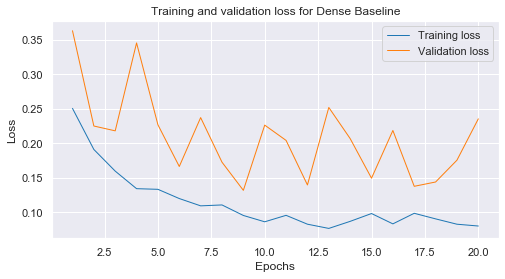

In [33]:
def DenseBaseline():
    model = Sequential()
    model.add(layers.Flatten(input_shape=(lookback // step, final_df2.shape[-1])))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

dense_base_start_time = time.time()
dense_baseline_model = rnn_model_generation(DenseBaseline(),"Dense Baseline")
dense_base_elapsed_time = time.time() - dense_base_start_time

## RNN Models

In [34]:
# RNN models
def BaseRNN(node_size):
    model = Sequential()
    model.add(layers.LSTM(node_size, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def BaseRNNWithDropout(node_size,val1,val2):
    model = Sequential()
    model.add(layers.LSTM(node_size, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def RNN2Layers(node_size):
    model = Sequential()
    model.add(layers.LSTM(node_size, return_sequences=True, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def RNN2LayersWithDropout(node_size,val1,val2):
    model = Sequential()
    model.add(layers.LSTM(node_size, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def RNN3Layers(node_size):
    model = Sequential()
    model.add(layers.LSTM(node_size, return_sequences=True, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size,return_sequences=True))
    model.add(layers.LSTM(node_size))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def RNN3LayersWithDropout(node_size,val1,val2):
    model = Sequential()
    model.add(layers.LSTM(node_size, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

## Single Layer

W0920 20:08:21.701890  8096 deprecation.py:323] From C:\Users\julia\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


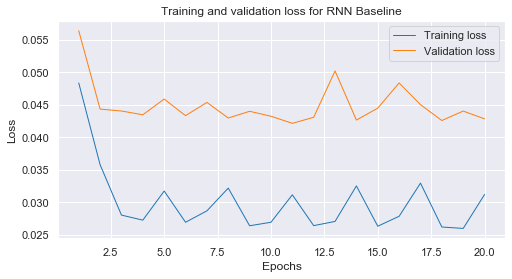

In [35]:
base_rnn_start_time = time.time()
base_rnn_model = rnn_model_generation(BaseRNN(32),"RNN Baseline")
base_rnn_elapsed_time = time.time() - base_rnn_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 32)                4480      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


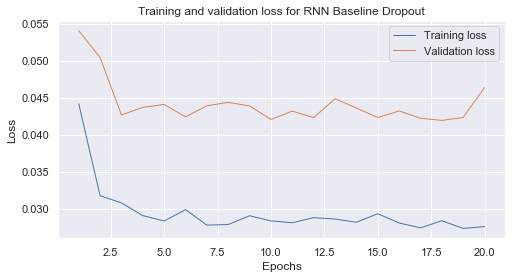

In [224]:
base_rnn_dropout_start_time = time.time()
base_rnn_dropout_model = rnn_model_generation(BaseRNNWithDropout(32,.2,.2),"RNN Baseline Dropout")
base_rnn_dropout_elapsed_time = time.time() - base_rnn_dropout_start_time

## Two Layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


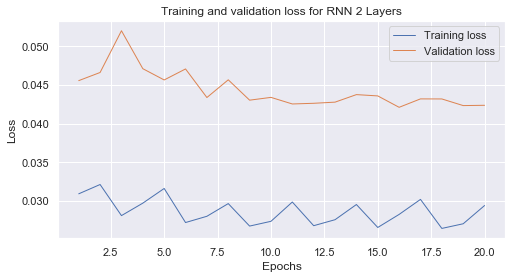

In [225]:
rnn_two_layers_start_time = time.time()
rnn_two_layers_model = rnn_model_generation(RNN2Layers(32),"RNN 2 Layers")
rnn_two_layers_elapsed_time = time.time() - rnn_two_layers_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


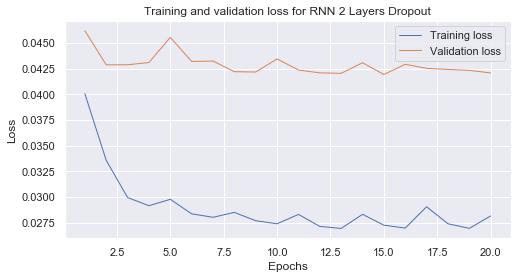

In [226]:
rnn_two_layers_dropout_start_time = time.time()
rnn_two_layers_dropout_model = rnn_model_generation(RNN2LayersWithDropout(32,.2,.2),"RNN 2 Layers Dropout")
rnn_two_layers_dropout_elapsed_time = time.time() - rnn_two_layers_dropout_start_time

## Three Layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


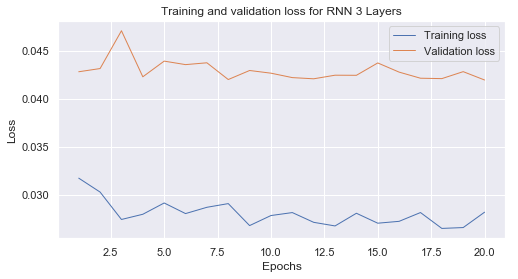

In [227]:
rnn_three_layers_start_time = time.time()
rnn_three_layers_model = rnn_model_generation(RNN3Layers(32),"RNN 3 Layers")
rnn_three_layers_elapsed_time = time.time() - rnn_three_layers_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_25 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


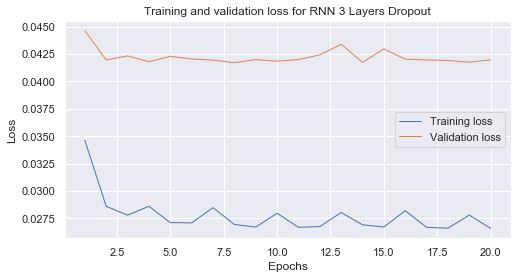

In [228]:
rnn_three_layers_dropout_start_time = time.time()
rnn_three_layers_dropout_model = rnn_model_generation(RNN3LayersWithDropout(32,.2,.2),"RNN 3 Layers Dropout")
rnn_three_layers_dropout_elapsed_time = time.time() - rnn_three_layers_dropout_start_time

## Different Dropout Values

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 32)                4480      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


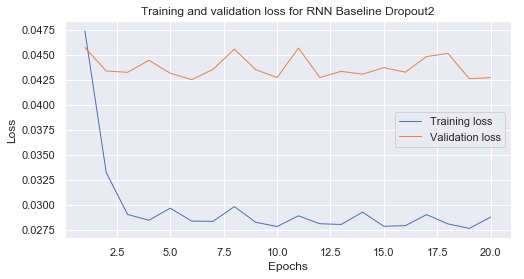

In [229]:
# let's try some different dropout values
base_rnn_dropout2_start_time = time.time()
base_rnn_dropout2_model = rnn_model_generation(BaseRNNWithDropout(32,.1,.5),"RNN Baseline Dropout2")
base_rnn_dropout2_elapsed_time = time.time() - base_rnn_dropout2_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


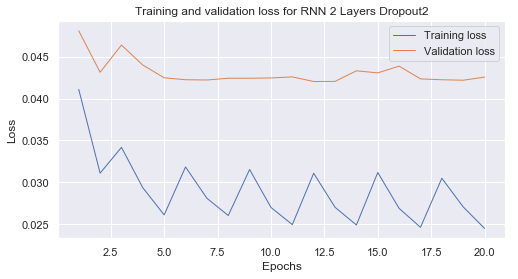

In [230]:
rnn_two_layers_dropout2_start_time = time.time()
rnn_two_layers_dropout2_model = rnn_model_generation(RNN2LayersWithDropout(32,.1,.5),"RNN 2 Layers Dropout2")
rnn_two_layers_dropout2_elapsed_time = time.time() - rnn_two_layers_dropout2_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_31 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


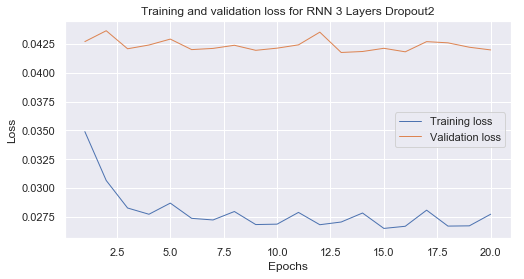

In [231]:
rnn_three_layers_dropout2_start_time = time.time()
rnn_three_layers_dropout2_model = rnn_model_generation(RNN3LayersWithDropout(32,.1,.5),"RNN 3 Layers Dropout2")
rnn_three_layers_dropout2_elapsed_time = time.time() - rnn_three_layers_dropout2_start_time

## Different Node Sizes

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, None, 64)          17152     
_________________________________________________________________
lstm_34 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 50,241
Trainable params: 50,241
Non-trainable params: 0
_________________________________________________________________


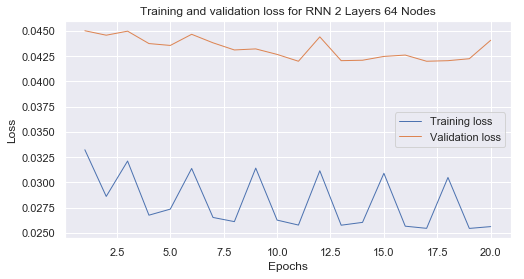

In [232]:
rnn_two_layers64_start_time = time.time()
rnn_two_layers64_model = rnn_model_generation(RNN2Layers(64),"RNN 2 Layers 64 Nodes")
rnn_two_layers64_elapsed_time = time.time() - rnn_two_layers64_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, None, 64)          17152     
_________________________________________________________________
lstm_36 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 50,241
Trainable params: 50,241
Non-trainable params: 0
_________________________________________________________________


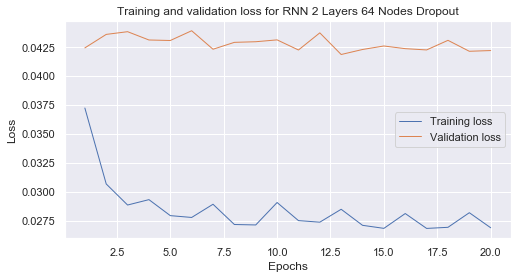

In [233]:
rnn_two_layers_dropout64_start_time = time.time()
rnn_two_layers_dropout64_model = rnn_model_generation(RNN2LayersWithDropout(64,.2,.2),"RNN 2 Layers 64 Nodes Dropout")
rnn_two_layers_dropout64_elapsed_time = time.time() - rnn_two_layers_dropout64_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, None, 128)         67072     
_________________________________________________________________
lstm_38 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________


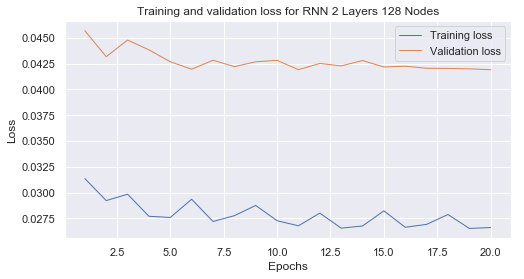

In [234]:
rnn_two_layers128_start_time = time.time()
rnn_two_layers128_model = rnn_model_generation(RNN2Layers(128),"RNN 2 Layers 128 Nodes")
rnn_two_layers128_elapsed_time = time.time() - rnn_two_layers128_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, None, 128)         67072     
_________________________________________________________________
lstm_40 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________


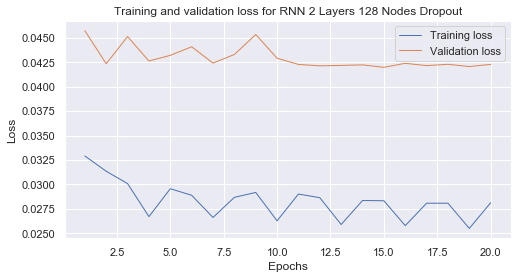

In [235]:
rnn_two_layers_dropout128_start_time = time.time()
rnn_two_layers_dropout128_model = rnn_model_generation(RNN2LayersWithDropout(128,.2,.2),"RNN 2 Layers 128 Nodes Dropout")
rnn_two_layers_dropout128_elapsed_time = time.time() - rnn_two_layers_dropout128_start_time

## Using Bidirectional RNNs

In [236]:
lookback = 90 # want this to be ~3 months based on seasonality
step = 1 # observations sampled 1 day at a time
delay = 60 # 2 mons in the future
batch_size = 16

def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(final_df2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1308,
                      step=step, 
                      batch_size=batch_size)
val_gen_reverse = reverse_order_generator(final_df2,
                    lookback=lookback,
                    delay=delay,
                    min_index=1309,
                    max_index=1459,
                    step=step,
                    batch_size=batch_size)
test_gen_reverse = reverse_order_generator(final_df2,
                     lookback=lookback,
                     delay=delay,
                     min_index=1460,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [237]:
from keras import layers
def rnn_model_generation_reverse(model, model_name):
    #reset_graph() # keep results consistent
    # builds the model that was defined above
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    # add a class weights argument b/c training data is imbalanced
    history = model.fit_generator(train_gen_reverse,steps_per_epoch=steps,epochs=num_epochs,validation_data=val_gen_reverse,validation_steps=val_steps,verbose=0)
    model.save(str(model_name+'.h5'))
    summary = model.summary()
    weights = model.get_weights()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8,4))
    loss_plot(history, model_name)
    plt.show()
    return summary, weights, history

def BidirectionalBase(node_size):
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(node_size), input_shape=(None, final_df2.shape[-1])))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def Bidirectional2Layers(node_size):
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(node_size, return_sequences=True), input_shape=(None, final_df2.shape[-1])))
    model.add(layers.Bidirectional(layers.LSTM(node_size)))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def Bidirectional3Layers(node_size):
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(node_size, return_sequences=True), input_shape=(None, final_df2.shape[-1])))
    model.add(layers.Bidirectional(layers.LSTM(node_size, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(node_size)))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def Bidirectional3LayersWithDropout(node_size,val1,val2):
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(node_size, dropout=val1, recurrent_dropout=val2, return_sequences=True), input_shape=(None, final_df2.shape[-1])))
    model.add(layers.Bidirectional(layers.LSTM(node_size, dropout=val1, recurrent_dropout=val2, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(node_size)))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 64)                8960      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


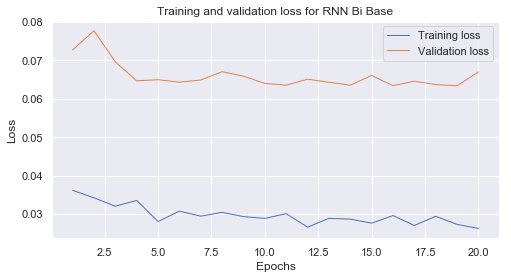

In [238]:
rnn_bi_base_start_time = time.time()
rnn_bi_base_model = rnn_model_generation_reverse(BidirectionalBase(32),"RNN Bi Base")
rnn_bi_base_elapsed_time = time.time() - rnn_bi_base_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, None, 128)         34304     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 129       
Total params: 133,249
Trainable params: 133,249
Non-trainable params: 0
_________________________________________________________________


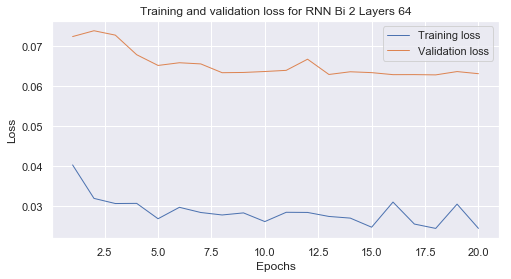

In [239]:
rnn_bi_two_layers_start_time = time.time()
rnn_bi_two_layers_model = rnn_model_generation_reverse(Bidirectional2Layers(64),"RNN Bi 2 Layers 64")
rnn_bi_two_layers_elapsed_time = time.time() - rnn_bi_two_layers_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, None, 128)         34304     
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 232,065
Trainable params: 232,065
Non-trainable params: 0
_________________________________________________________________


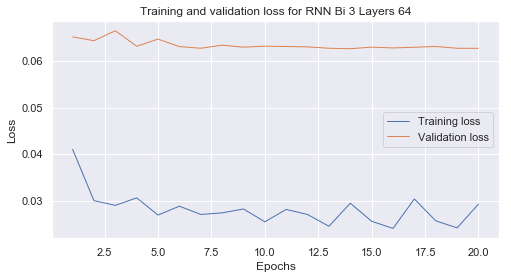

In [240]:
rnn_bi_three_layers_start_time = time.time()
rnn_bi_three_layers_model = rnn_model_generation_reverse(Bidirectional3Layers(64),"RNN Bi 3 Layers 64")
rnn_bi_three_layers_elapsed_time = time.time() - rnn_bi_three_layers_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, None, 256)         134144    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 256)         394240    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 922,881
Trainable params: 922,881
Non-trainable params: 0
_________________________________________________________________


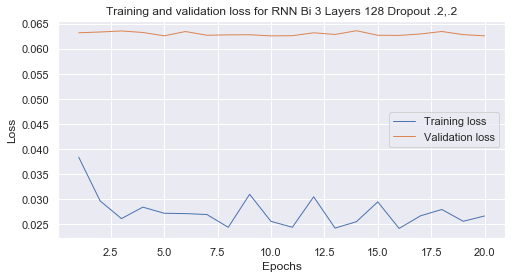

In [241]:
rnn_bi_three_layers128_start_time = time.time()
rnn_bi_three_layers128_model = rnn_model_generation_reverse(Bidirectional3LayersWithDropout(128,.2,.2),"RNN Bi 3 Layers 128 Dropout .2,.2")
rnn_bi_three_layers128_elapsed_time = time.time() - rnn_bi_three_layers128_start_time


## Adjust Learning Rate

In [242]:
# try .0001 and .1
# not sure which model configuration should be tried though...wait and see
from keras import optimizers
def RNN2LayersLR(node_size1,val1,val2,lr):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(lr=lr), loss='mae')
    return model

def RNN3LayersLRBase(node_size1,val1,val2,lr):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(lr=lr), loss='mae')
    return model

def RNN3LayersLROneDense(node_size1,node_size2,val1,val2,lr):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(lr=lr), loss='mae')
    return model

def RNN3LayersLR(node_size1,node_size2,val1,val2,lr):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(lr=lr), loss='mae')
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_51 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


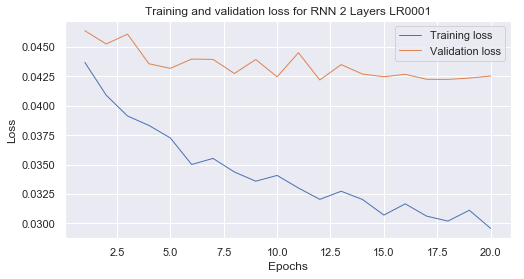

In [243]:
rnn_two_layers_lr0001_start_time = time.time()
rnn_two_layers_lr0001_model = rnn_model_generation(RNN2LayersLR(32,.2,.2,.0001),"RNN 2 Layers LR0001")
rnn_two_layers_lr0001_elapsed_time = time.time() - rnn_two_layers_lr0001_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_53 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


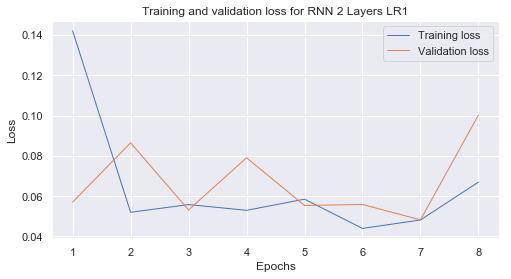

In [244]:
rnn_two_layers_lr1_start_time = time.time()
rnn_two_layers_lr1_model = rnn_model_generation(RNN2LayersLR(32,.2,.2,.1),"RNN 2 Layers LR1")
rnn_two_layers_lr1_elapsed_time = time.time() - rnn_two_layers_lr1_start_time

In [246]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4480      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 27,457
Trainable params: 27,457
Non-trainable params: 0
_________________________________________________________________


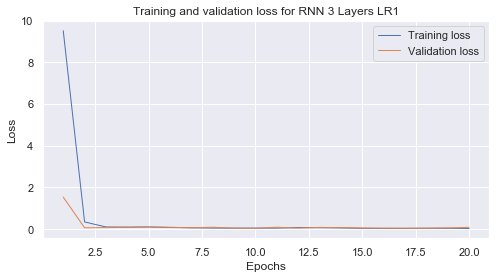

In [247]:
rnn_three_layers_lr1_start_time = time.time()
rnn_three_layers_lr1_model = rnn_model_generation(RNN3LayersLR(32,64,.2,.2,.1),"RNN 3 Layers LR1")
rnn_three_layers_lr1_elapsed_time = time.time() - rnn_three_layers_lr1_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 32)          4480      
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 27,457
Trainable params: 27,457
Non-trainable params: 0
_________________________________________________________________


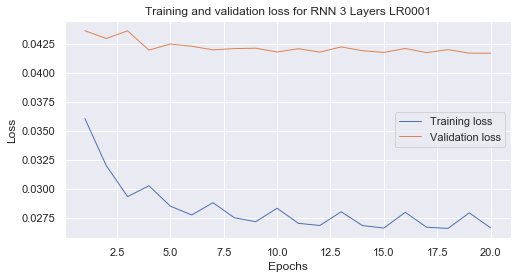

In [248]:
rnn_three_layers_lr0001_start_time = time.time()
rnn_three_layers_lr0001_model = rnn_model_generation(RNN3LayersLR(32,64,.2,.2,.0001),"RNN 3 Layers LR0001")
rnn_three_layers_lr0001_elapsed_time = time.time() - rnn_three_layers_lr0001_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 32)          4480      
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


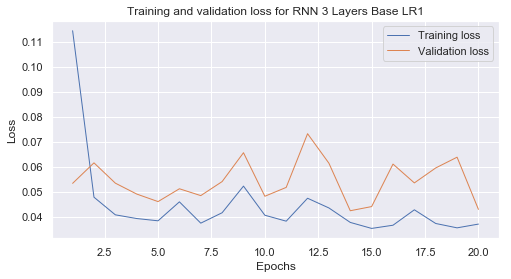

In [249]:
rnn_three_layers_lr1_base_start_time = time.time()
rnn_three_layers_lr1_base_model = rnn_model_generation(RNN3LayersLRBase(32,.2,.2,.1),"RNN 3 Layers Base LR1")
rnn_three_layers_lr1_base_elapsed_time = time.time() - rnn_three_layers_lr1_base_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________


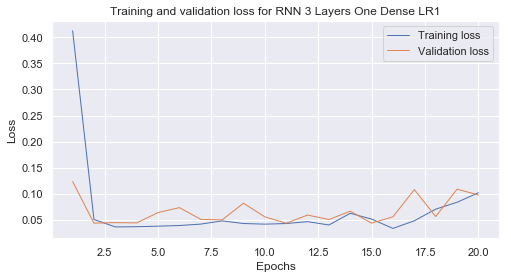

In [250]:
rnn_three_layers_lr1_onedense_start_time = time.time()
rnn_three_layers_lr1_onedense_model = rnn_model_generation(RNN3LayersLROneDense(32,64,.2,.2,.1),"RNN 3 Layers One Dense LR1")
rnn_three_layers_lr1_onedense_elapsed_time = time.time() - rnn_three_layers_lr1_onedense_start_time

## Add More Densely Connected Layers at the End

In [251]:
def RNN3LayersDense(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def RNN3LayersDense2(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def RNN2LayersDense(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 14,977
Trainable params: 14,977
Non-trainable params: 0
_________________________________________________________________


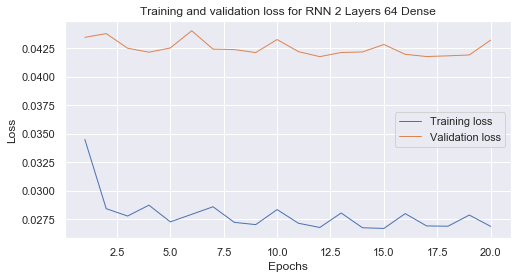

In [252]:
rnn_two_layers_dense_start_time = time.time()
rnn_two_layers_dense_model = rnn_model_generation(RNN2LayersDense(32,64,.2,.2),"RNN 2 Layers 64 Dense")
rnn_two_layers_dense_elapsed_time = time.time() - rnn_two_layers_dense_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________


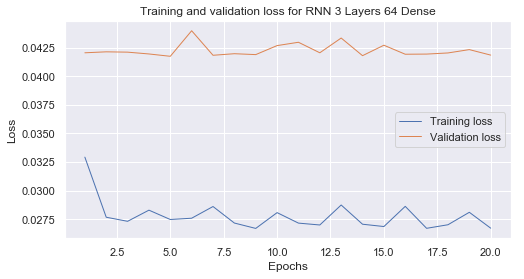

In [336]:
rnn_three_layers_dense_start_time = time.time()
rnn_three_layers_dense_model = rnn_model_generation(RNN3LayersDense(32,64,.2,.2),"RNN 3 Layers 64 Dense")
rnn_three_layers_dense_elapsed_time = time.time() - rnn_three_layers_dense_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 27,457
Trainable params: 27,457
Non-trainable params: 0
_________________________________________________________________


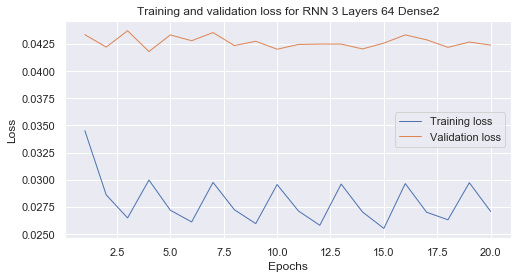

In [337]:
rnn_three_layers_dense_start_time2 = time.time()
rnn_three_layers_dense_model2 = rnn_model_generation(RNN3LayersDense2(32,64,.2,.2),"RNN 3 Layers 64 Dense2")
rnn_three_layers_dense_elapsed_time2 = time.time() - rnn_three_layers_dense_start_time2

## Initial Summary of Results

In [311]:
# table of results
# this is large & cumbersome....function wouldn't really help that much b/c still have to assign all these variables
# dense base
dense_base_mae = '{:.2}'.format(np.mean(dense_baseline_model[2].history['loss']))
dense_base_val_mae = '{:.2}'.format(np.mean(dense_baseline_model[2].history['val_loss']))
# rnn base
rnn_base_mae = '{:.2}'.format(np.mean(base_rnn_model[2].history['loss']))
rnn_base_val_mae = '{:.2}'.format(np.mean(base_rnn_model[2].history['val_loss']))
# rnn base dropout
rnn_base_dropout_mae = '{:.2}'.format(np.mean(base_rnn_dropout_model[2].history['loss']))
rnn_base_dropout_val_mae = '{:.2}'.format(np.mean(base_rnn_dropout_model[2].history['val_loss']))
# rnn 2 layers
rnn_2layers_mae = '{:.2}'.format(np.mean(rnn_two_layers_model[2].history['loss']))
rnn_2layers_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_model[2].history['val_loss']))
# rnn 2 layers dropout
rnn_2layers_dropout_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout_model[2].history['loss']))
rnn_2layers_dropout_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout_model[2].history['val_loss']))
# rnn 3 layers
rnn_3layers_mae = '{:.2}'.format(np.mean(rnn_three_layers_model[2].history['loss']))
rnn_3layers_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_model[2].history['val_loss']))
# rnn 3 layers dropout
rnn_3layers_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout_model[2].history['loss']))
rnn_3layers_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout_model[2].history['val_loss']))

# different dropout vals
rnn_base_dropout2_mae = '{:.2}'.format(np.mean(base_rnn_dropout2_model[2].history['loss']))
rnn_base_dropout2_val_mae = '{:.2}'.format(np.mean(base_rnn_dropout2_model[2].history['val_loss']))
rnn_2layers_dropout2_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout2_model[2].history['loss']))
rnn_2layers_dropout2_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout2_model[2].history['val_loss']))
rnn_3layers_dropout2_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout2_model[2].history['loss']))
rnn_3layers_dropout2_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout2_model[2].history['val_loss']))

# change node sizes
rnn_2layers64_mae = '{:.2}'.format(np.mean(rnn_two_layers64_model[2].history['loss']))
rnn_2layers64_val_mae = '{:.2}'.format(np.mean(rnn_two_layers64_model[2].history['val_loss']))
rnn_2layers64_dropout_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout64_model[2].history['loss']))
rnn_2layers64_dropout_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout64_model[2].history['val_loss']))

rnn_2layers128_mae = '{:.2}'.format(np.mean(rnn_two_layers128_model[2].history['loss']))
rnn_2layers128_val_mae = '{:.2}'.format(np.mean(rnn_two_layers128_model[2].history['val_loss']))
rnn_2layers128_dropout_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout128_model[2].history['loss']))
rnn_2layers128_dropout_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout128_model[2].history['val_loss']))

# add more densely connected layers
rnn_2layers_dense_mae = '{:.2}'.format(np.mean(rnn_two_layers_dense_model[2].history['loss']))
rnn_2layers_dense_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dense_model[2].history['val_loss']))

rnn_3layers_dense_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_model[2].history['loss']))
rnn_3layers_dense_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_model[2].history['val_loss']))

rnn_3layers_dense_mae2 = '{:.2}'.format(np.mean(rnn_three_layers_dense_model2[2].history['loss']))
rnn_3layers_dense_val_mae2 = '{:.2}'.format(np.mean(rnn_three_layers_dense_model2[2].history['val_loss']))

# learning rate models
rnn_2layers_lr0001_mae = '{:.2}'.format(np.mean(rnn_two_layers_lr0001_model[2].history['loss']))
rnn_2layers_lr0001_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_lr0001_model[2].history['val_loss']))

# was getting nan vals for some reason - this took so long to generate so not building again
cleaned_mae_list = [x for x in rnn_two_layers_lr1_model[2].history['loss'] if x == x]
cleaned_val_mae_list = [x for x in rnn_two_layers_lr1_model[2].history['val_loss'] if x == x]
rnn_2layers_lr1_mae = '{:.2}'.format(np.mean(cleaned_mae_list))
rnn_2layers_lr1_val_mae = '{:.2}'.format(np.mean(cleaned_val_mae_list))

rnn_3layers_lr0001_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr0001_model[2].history['loss']))
rnn_3layers_lr0001_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr0001_model[2].history['val_loss']))

rnn_3layers_lr1_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_model[2].history['loss']))
rnn_3layers_lr1_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_model[2].history['val_loss']))

rnn_3layers_lr1_dense_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_onedense_model[2].history['loss']))
rnn_3layers_lr1_dense_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_onedense_model[2].history['val_loss']))

rnn_3layers_lr1_base_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_base_model[2].history['loss']))
rnn_3layers_lr1_base_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_base_model[2].history['val_loss']))

# bi-directional RNNs
rnn_bi_three_layers_mae128 = '{:.2}'.format(np.mean(rnn_bi_three_layers128_model[2].history['loss']))
rnn_bi_three_layers_val_mae128 = '{:.2}'.format(np.mean(rnn_bi_three_layers128_model[2].history['val_loss']))

rnn_bi_three_layers_mae = '{:.2}'.format(np.mean(rnn_bi_three_layers_model[2].history['loss']))
rnn_bi_three_layers_val_mae = '{:.2}'.format(np.mean(rnn_bi_three_layers_model[2].history['val_loss']))

rnn_bi_two_layers_mae = '{:.2}'.format(np.mean(rnn_bi_two_layers_model[2].history['loss']))
rnn_bi_two_layers_val_mae = '{:.2}'.format(np.mean(rnn_bi_two_layers_model[2].history['val_loss']))

rnn_bi_base_mae = '{:.2}'.format(np.mean(rnn_bi_base_model[2].history['loss']))
rnn_bi_base_val_mae = '{:.2}'.format(np.mean(rnn_bi_base_model[2].history['val_loss']))

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Train MAE', 'Val MAE', 'Processing Time']
# align fields
a.align["Model"] = "l"
a.align["Layers/Nodes"] = "l"
a.align["Train MAE"] = "l"
a.align["Val MAE"] = "l"
a.align["Processing Time"] = "l"
# basic models
a.add_row(['Dense', '32', dense_base_mae, dense_base_val_mae, round(dense_base_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32', rnn_base_mae, rnn_base_val_mae, round(base_rnn_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32 w/ dropout .2,.2', rnn_base_dropout_mae, rnn_base_dropout_val_mae, round(base_rnn_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32', rnn_2layers_mae, rnn_2layers_val_mae, round(rnn_two_layers_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32 w/ dropout .2,.2', rnn_2layers_dropout_mae, rnn_2layers_dropout_val_mae, round(rnn_two_layers_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32,32', rnn_3layers_mae, rnn_3layers_val_mae, round(rnn_three_layers_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32,32 w/ dropout .2,.2', rnn_3layers_dropout_mae, rnn_3layers_dropout_val_mae, round(rnn_three_layers_dropout_elapsed_time,1)])
# change dropout layers
a.add_row(['RNN w/ LSTM - Dropout', '32 w/ dropout .1,.5', rnn_base_dropout2_mae, rnn_base_dropout2_val_mae, round(base_rnn_dropout2_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Dropout', '32,32 w/ dropout .1,.5', rnn_2layers_dropout2_mae, rnn_2layers_dropout2_val_mae, round(rnn_two_layers_dropout2_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Dropout', '32,32,32 w/ dropout .1,.5', rnn_3layers_dropout2_mae, rnn_3layers_dropout2_val_mae, round(rnn_three_layers_dropout2_elapsed_time,1)])
# change node sizes
a.add_row(['RNN w/ LSTM - Node', '64,64', rnn_2layers64_mae, rnn_2layers64_val_mae, round(rnn_two_layers64_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Node', '64,64 w/ dropout .2,.2', rnn_2layers64_dropout_mae, rnn_2layers64_dropout_val_mae, round(rnn_two_layers_dropout64_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Node', '128,128', rnn_2layers128_mae, rnn_2layers128_val_mae, round(rnn_two_layers128_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Node', '128,128 w/ dropout .2,.2', rnn_2layers128_dropout_mae, rnn_2layers128_dropout_val_mae, round(rnn_two_layers_dropout128_elapsed_time,1)])
# more densely connected layers
a.add_row(['RNN w/ LSTM - Extra Dense', '32(2 LSTM),64(1 dense) w/ dropout .2,.2', rnn_2layers_dense_mae, rnn_2layers_dense_val_mae, round(rnn_two_layers_dense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense', '32(3 LSTM),64(1 dense) w/ dropout .2,.2', rnn_3layers_dense_mae, rnn_3layers_dense_val_mae, round(rnn_three_layers_dense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense', '32(3 LSTM),64(2 dense) w/ dropout .2,.2', rnn_3layers_dense_mae, rnn_3layers_dense_val_mae, round(rnn_three_layers_dense_elapsed_time2,1)])
# learning rate models
a.add_row(['RNN w/ LSTM LR=.0001', '32,32 w/ dropout .2,.2', rnn_2layers_lr0001_mae, rnn_2layers_lr0001_val_mae, round(rnn_two_layers_lr0001_elapsed_time,1)])
a.add_row(['RNN w/ LSTM LR=.1', '32,32 w/ dropout .2,.2', rnn_2layers_lr1_mae, rnn_2layers_lr1_val_mae, round(rnn_two_layers_lr1_elapsed_time,1)])
a.add_row(['RNN w/ LSTM LR=.1', '32,32,32 w/ dropout .2,.2', rnn_3layers_lr1_base_mae, rnn_3layers_lr1_base_val_mae, round(rnn_three_layers_lr1_base_elapsed_time,1)])
a.add_row(['RNN w/ LSTM LR=.1', '32(3 LSTM),64(1 dense) w/ dropout .2,.2', rnn_3layers_lr1_dense_mae, rnn_3layers_lr1_dense_val_mae, round(rnn_three_layers_lr1_onedense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM LR=.0001', '32(3 LSTM),64(2 dense) w/ dropout .2,.2', rnn_3layers_lr0001_mae, rnn_3layers_lr0001_val_mae, round(rnn_three_layers_lr0001_elapsed_time,1)])
a.add_row(['RNN w/ LSTM LR=.1', '32(3 LSTM),64(2 dense) w/ dropout .2,.2', rnn_3layers_lr1_mae, rnn_3layers_lr1_val_mae, round(rnn_three_layers_lr1_elapsed_time,1)])
# bidirectional RNNs
a.add_row(['Bidirectional RNN w/ LSTM', '32', rnn_bi_base_mae, rnn_bi_base_val_mae, round(rnn_bi_base_elapsed_time,1)])
a.add_row(['Bidirectional RNN w/ LSTM', '64,64', rnn_bi_two_layers_mae, rnn_bi_two_layers_val_mae, round(rnn_bi_two_layers_elapsed_time,1)])
a.add_row(['Bidirectional RNN w/ LSTM', '64,64,64', rnn_bi_three_layers_mae, rnn_bi_three_layers_val_mae, round(rnn_bi_three_layers_elapsed_time,1)])
a.add_row(['Bidirectional RNN w/ LSTM', '128,128,128', rnn_bi_three_layers_mae128, rnn_bi_three_layers_val_mae128, round(rnn_bi_three_layers128_elapsed_time,1)])
print(a.get_string(title="RNN Training Results"))


+-------------------------------------------------------------------------------------------------------------+
|                                             RNN Training Results                                            |
+---------------------------+-----------------------------------------+-----------+---------+-----------------+
| Model                     | Layers/Nodes                            | Train MAE | Val MAE | Processing Time |
+---------------------------+-----------------------------------------+-----------+---------+-----------------+
| Dense                     | 32                                      | 0.15      | 0.26    | 21.6            |
| RNN w/ LSTM - Basic       | 32                                      | 0.03      | 0.045   | 110.7           |
| RNN w/ LSTM - Basic       | 32 w/ dropout .2,.2                     | 0.029     | 0.044   | 124.3           |
| RNN w/ LSTM - Basic       | 32,32                                   | 0.029     | 0.044   | 203.0     

## Testing some other RNN architectures

In [255]:
def RNN3LayersDenseLR(node_size1,node_size2,val1,val2,lr):
    model = Sequential()
    model.add(layers.LSTM(node_size1, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size1, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(node_size2))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(lr=lr), loss='mae')
    return model

In [256]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4480      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________


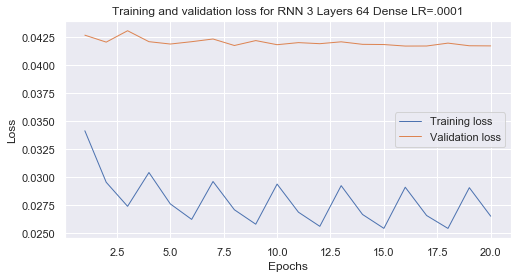

In [257]:
rnn_three_layers_dense_lr0001_start_time = time.time()
rnn_three_layers_dense_lr0001_model = rnn_model_generation(RNN3LayersDenseLR(32,64,.2,.2,.0001),"RNN 3 Layers 64 Dense LR=.0001")
rnn_three_layers_dense_lr0001_elapsed_time = time.time() - rnn_three_layers_dense_lr0001_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 32)          4480      
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________


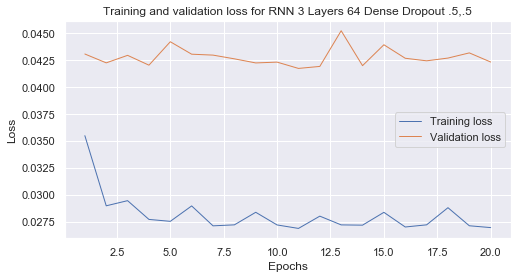

In [258]:
rnn_three_layers_dense_largedropout_start_time = time.time()
rnn_three_layers_dense_largedropout_model = rnn_model_generation(RNN3LayersDenseLR(32,64,.5,.5,.001),"RNN 3 Layers 64 Dense Dropout .5,.5")
rnn_three_layers_dense_largedropout_elapsed_time = time.time() - rnn_three_layers_dense_largedropout_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 32)          4480      
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________


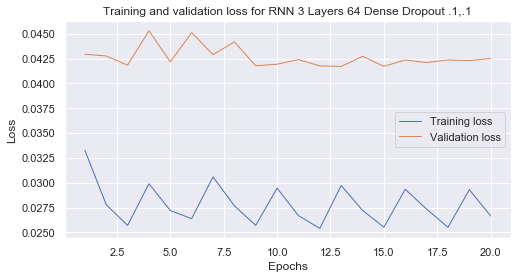

In [259]:
rnn_three_layers_dense_smalldropout_start_time = time.time()
rnn_three_layers_dense_smalldropout_model = rnn_model_generation(RNN3LayersDenseLR(32,64,.1,.1,.001),"RNN 3 Layers 64 Dense Dropout .1,.1")
rnn_three_layers_dense_smalldropout_elapsed_time = time.time() - rnn_three_layers_dense_smalldropout_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 64)          17152     
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 83,265
Trainable params: 83,265
Non-trainable params: 0
_________________________________________________________________


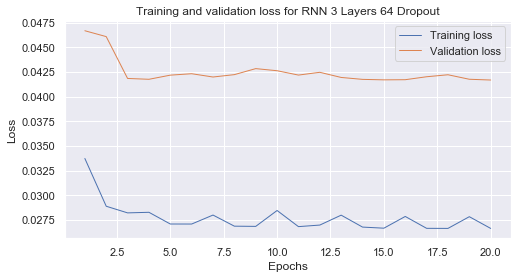

In [260]:
# other baseline models
rnn_three_layers64_dropout_start_time = time.time()
rnn_three_layers64_dropout_model = rnn_model_generation(RNN3LayersWithDropout(64,.2,.2),"RNN 3 Layers 64 Dropout")
rnn_three_layers64_dropout_elapsed_time = time.time() - rnn_three_layers64_dropout_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 128)         67072     
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 330,369
Trainable params: 330,369
Non-trainable params: 0
_________________________________________________________________


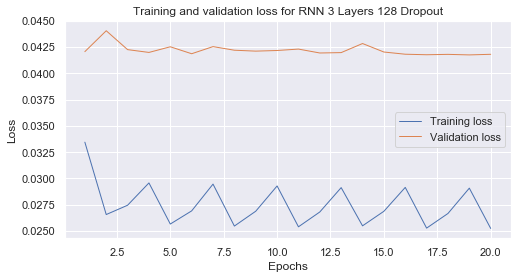

In [261]:
rnn_three_layers128_dropout_start_time = time.time()
rnn_three_layers128_dropout_model = rnn_model_generation(RNN3LayersWithDropout(128,.2,.2),"RNN 3 Layers 128 Dropout")
rnn_three_layers128_dropout_elapsed_time = time.time() - rnn_three_layers128_dropout_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, None, 128)         67072     
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


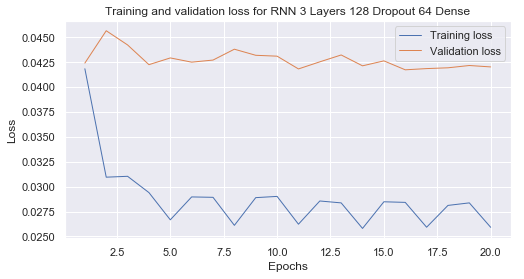

In [262]:
rnn_three_layers128_dropout_dense_start_time = time.time()
rnn_three_layers128_dropout_dense_model = rnn_model_generation(RNN3LayersDenseLR(128,64,.5,.5,.001),"RNN 3 Layers 128 Dropout 64 Dense")
rnn_three_layers128_dropout_dense_elapsed_time = time.time() - rnn_three_layers128_dropout_dense_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, None, 256)         265216    
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
lstm_21 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 1,316,097
Trainable params: 1,316,097
Non-trainable params: 0
_________________________________________________________________


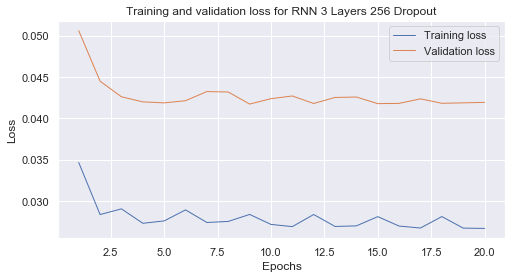

In [263]:
rnn_three_layers256_dropout_start_time2 = time.time()
rnn_three_layers256_dropout_model2 = rnn_model_generation(RNN3LayersWithDropout(256,.2,.2),"RNN 3 Layers 256 Dropout")
rnn_three_layers256_dropout_elapsed_time2 = time.time() - rnn_three_layers256_dropout_start_time2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, None, 256)         265216    
_________________________________________________________________
lstm_23 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
lstm_24 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 1,316,097
Trainable params: 1,316,097
Non-trainable params: 0
_________________________________________________________________


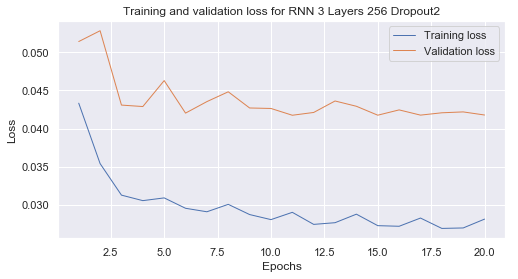

In [264]:
rnn_three_layers256_dropout_start_time = time.time()
rnn_three_layers256_dropout_model = rnn_model_generation(RNN3LayersWithDropout(256,.5,.5),"RNN 3 Layers 256 Dropout2")
rnn_three_layers256_dropout_elapsed_time = time.time() - rnn_three_layers256_dropout_start_time

In [265]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 256)         265216    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,332,353
Trainable params: 1,332,353
Non-trainable params: 0
_________________________________________________________________


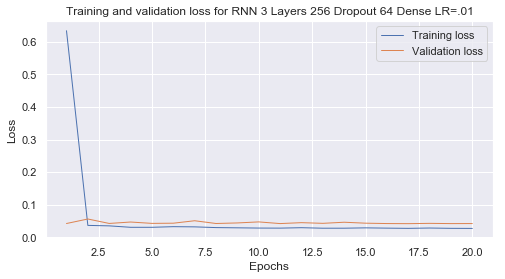

In [266]:
# test some other LR
# 256 nodes is most flat
rnn_three_layers256_dropout_dense_lr01_start_time = time.time()
rnn_three_layers256_dropout_dense_lr01_model = rnn_model_generation(RNN3LayersDenseLR(256,64,.2,.2,.01),"RNN 3 Layers 256 Dropout 64 Dense LR=.01")
rnn_three_layers256_dropout_denselr01__elapsed_time = time.time() - rnn_three_layers256_dropout_dense_lr01_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 256)         265216    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,332,353
Trainable params: 1,332,353
Non-trainable params: 0
_________________________________________________________________


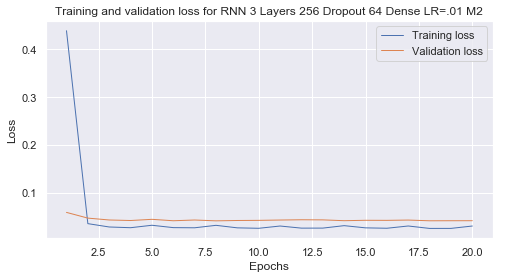

In [268]:
rnn_three_layers256_dropout_dense_lr01_start_time2 = time.time()
rnn_three_layers256_dropout_dense_lr01_model2 = rnn_model_generation(RNN3LayersDenseLR(256,64,.5,.5,.01),"RNN 3 Layers 256 Dropout 64 Dense LR=.01 M2")
rnn_three_layers256_dropout_denselr01__elapsed_time2 = time.time() - rnn_three_layers256_dropout_dense_lr01_start_time2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4480      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________


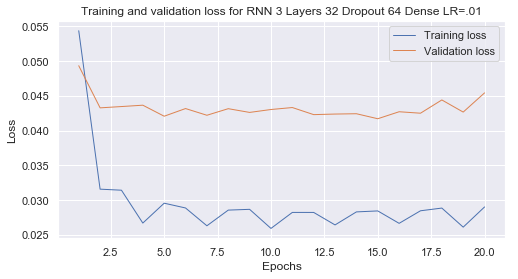

In [319]:
rnn_three_layers32_dropout_dense_lr01_start_time = time.time()
rnn_three_layers32_dropout_dense_lr01_model = rnn_model_generation(RNN3LayersDenseLR(32,64,.2,.2,.01),"RNN 3 Layers 32 Dropout 64 Dense LR=.01")
rnn_three_layers32_dropout_denselr01_elapsed_time = time.time() - rnn_three_layers32_dropout_dense_lr01_start_time

## Summarize Additional Architecture Results

In [323]:
# table of results
rnn_three_layers_dense_lr0001_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_lr0001_model[2].history['loss']))
rnn_three_layers_dense_lr0001_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_lr0001_model[2].history['val_loss']))

rnn_three_layers_dense_largedropout_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_largedropout_model[2].history['loss']))
rnn_three_layers_dense_largedropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_largedropout_model[2].history['val_loss']))

rnn_three_layers_dense_smalldropout_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_smalldropout_model[2].history['loss']))
rnn_three_layers_dense_smalldropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_smalldropout_model[2].history['val_loss']))

# other baseline models - node size/dropout
rnn_three_layers64_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers64_dropout_model[2].history['loss']))
rnn_three_layers64_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers64_dropout_model[2].history['val_loss']))

rnn_three_layers128_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_model[2].history['loss']))
rnn_three_layers128_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_model[2].history['val_loss']))

rnn_three_layers128_dropout_dense_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_dense_model[2].history['loss']))
rnn_three_layers128_dropout_dense_val_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_dense_model[2].history['val_loss']))

rnn_three_layers256_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_model[2].history['loss']))
rnn_three_layers256_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_model[2].history['val_loss']))

# other iterations
rnn_three_layers32_dropout_dense_lr01_mae = '{:.2}'.format(np.mean(rnn_three_layers32_dropout_dense_lr01_model[2].history['loss']))
rnn_three_layers32_dropout_dense_lr01_val_mae = '{:.2}'.format(np.mean(rnn_three_layers32_dropout_dense_lr01_model[2].history['val_loss']))

rnn_three_layers256_dropout_dense_lr01_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model[2].history['loss']))
rnn_three_layers256_dropout_dense_lr01_val_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model[2].history['val_loss']))

rnn_three_layers256_dropout_dense_lr01_mae2 = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model2[2].history['loss']))
rnn_three_layers256_dropout_dense_lr01_val_mae2 = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model2[2].history['val_loss']))

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Train MAE', 'Val MAE', 'Processing Time']
# align fields
a.align["Model"] = "l"
a.align["Layers/Nodes"] = "l"
a.align["Train MAE"] = "l"
a.align["Val MAE"] = "l"
a.align["Processing Time"] = "l"
# basic models
a.add_row(['RNN w/ LSTM - Basic', '64,64,64 w/ dropout .2,.2', rnn_three_layers64_dropout_mae, rnn_three_layers64_dropout_val_mae, round(rnn_three_layers64_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '128,128,128 w/ dropout .2,.2', rnn_three_layers128_dropout_mae, rnn_three_layers128_dropout_val_mae, round(rnn_three_layers128_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '256,256,256 w/ dropout .5,.5', rnn_three_layers256_dropout_mae, rnn_three_layers256_dropout_val_mae, round(rnn_three_layers256_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.0001', '32,32,32,64 w/ dropout .2,.2', rnn_three_layers_dense_lr0001_mae, rnn_three_layers_dense_lr0001_val_mae, round(rnn_three_layers_dense_lr0001_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.0001', '32,32,32,64 w/ dropout .5,.5', rnn_three_layers_dense_largedropout_mae, rnn_three_layers_dense_largedropout_val_mae, round(rnn_three_layers_dense_largedropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.0001', '32,32,32,64 w/ dropout .1.,1', rnn_three_layers_dense_smalldropout_mae, rnn_three_layers_dense_smalldropout_val_mae, round(rnn_three_layers_dense_smalldropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.001', '128,128,128,64 w/ dropout .5,.5', rnn_three_layers128_dropout_dense_mae, rnn_three_layers128_dropout_dense_val_mae, round(rnn_three_layers128_dropout_dense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.01', '32,32,32,64 w/ dropout .2,.2', rnn_three_layers32_dropout_dense_lr01_mae, rnn_three_layers32_dropout_dense_lr01_val_mae, round(rnn_three_layers32_dropout_denselr01_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.01', '256,256,256,64 w/ dropout .2,.2', rnn_three_layers256_dropout_dense_lr01_mae, rnn_three_layers256_dropout_dense_lr01_val_mae, round(rnn_three_layers256_dropout_denselr01__elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.01', '256,256,256,64 w/ dropout .5,.5', rnn_three_layers256_dropout_dense_lr01_mae2, rnn_three_layers256_dropout_dense_lr01_val_mae2, round(rnn_three_layers256_dropout_denselr01__elapsed_time2,1)])
print(a.get_string(title="RNN Training Results"))

+--------------------------------------------------------------------------------------------------------------+
|                                             RNN Training Results                                             |
+------------------------------------+---------------------------------+-----------+---------+-----------------+
| Model                              | Layers/Nodes                    | Train MAE | Val MAE | Processing Time |
+------------------------------------+---------------------------------+-----------+---------+-----------------+
| RNN w/ LSTM - Basic                | 64,64,64 w/ dropout .2,.2       | 0.028     | 0.043   | 355.8           |
| RNN w/ LSTM - Basic                | 128,128,128 w/ dropout .2,.2    | 0.027     | 0.042   | 406.8           |
| RNN w/ LSTM - Basic                | 256,256,256 w/ dropout .5,.5    | 0.03      | 0.044   | 772.6           |
| RNN w/ LSTM - Extra Dense LR=.0001 | 32,32,32,64 w/ dropout .2,.2    | 0.028     | 0.042   | 3

## Summarize RNN Results

In [338]:
# table of results
# dense base
dense_base_mae = '{:.2}'.format(np.mean(dense_baseline_model[2].history['loss']))
dense_base_val_mae = '{:.2}'.format(np.mean(dense_baseline_model[2].history['val_loss']))
# rnn base
rnn_base_mae = '{:.2}'.format(np.mean(base_rnn_model[2].history['loss']))
rnn_base_val_mae = '{:.2}'.format(np.mean(base_rnn_model[2].history['val_loss']))
# rnn base dropout
rnn_base_dropout_mae = '{:.2}'.format(np.mean(base_rnn_dropout_model[2].history['loss']))
rnn_base_dropout_val_mae = '{:.2}'.format(np.mean(base_rnn_dropout_model[2].history['val_loss']))
# rnn 2 layers
rnn_2layers_mae = '{:.2}'.format(np.mean(rnn_two_layers_model[2].history['loss']))
rnn_2layers_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_model[2].history['val_loss']))
# rnn 2 layers dropout
rnn_2layers_dropout_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout_model[2].history['loss']))
rnn_2layers_dropout_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout_model[2].history['val_loss']))
# rnn 3 layers
rnn_3layers_mae = '{:.2}'.format(np.mean(rnn_three_layers_model[2].history['loss']))
rnn_3layers_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_model[2].history['val_loss']))
# rnn 3 layers dropout
rnn_3layers_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout_model[2].history['loss']))
rnn_3layers_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout_model[2].history['val_loss']))

# different dropout vals
rnn_base_dropout2_mae = '{:.2}'.format(np.mean(base_rnn_dropout2_model[2].history['loss']))
rnn_base_dropout2_val_mae = '{:.2}'.format(np.mean(base_rnn_dropout2_model[2].history['val_loss']))
rnn_2layers_dropout2_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout2_model[2].history['loss']))
rnn_2layers_dropout2_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout2_model[2].history['val_loss']))
rnn_3layers_dropout2_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout2_model[2].history['loss']))
rnn_3layers_dropout2_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dropout2_model[2].history['val_loss']))

# change node sizes
rnn_2layers64_mae = '{:.2}'.format(np.mean(rnn_two_layers64_model[2].history['loss']))
rnn_2layers64_val_mae = '{:.2}'.format(np.mean(rnn_two_layers64_model[2].history['val_loss']))
rnn_2layers64_dropout_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout64_model[2].history['loss']))
rnn_2layers64_dropout_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout64_model[2].history['val_loss']))

rnn_2layers128_mae = '{:.2}'.format(np.mean(rnn_two_layers128_model[2].history['loss']))
rnn_2layers128_val_mae = '{:.2}'.format(np.mean(rnn_two_layers128_model[2].history['val_loss']))
rnn_2layers128_dropout_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout128_model[2].history['loss']))
rnn_2layers128_dropout_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dropout128_model[2].history['val_loss']))

# add more densely connected layers
rnn_2layers_dense_mae = '{:.2}'.format(np.mean(rnn_two_layers_dense_model[2].history['loss']))
rnn_2layers_dense_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_dense_model[2].history['val_loss']))

rnn_3layers_dense_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_model[2].history['loss']))
rnn_3layers_dense_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_model[2].history['val_loss']))

rnn_3layers_dense_mae2 = '{:.2}'.format(np.mean(rnn_three_layers_dense_model2[2].history['loss']))
rnn_3layers_dense_val_mae2 = '{:.2}'.format(np.mean(rnn_three_layers_dense_model2[2].history['val_loss']))

# learning rate models
rnn_2layers_lr0001_mae = '{:.2}'.format(np.mean(rnn_two_layers_lr0001_model[2].history['loss']))
rnn_2layers_lr0001_val_mae = '{:.2}'.format(np.mean(rnn_two_layers_lr0001_model[2].history['val_loss']))

# was getting nan vals for some reason - this took so long to generate so not building again
cleaned_mae_list = [x for x in rnn_two_layers_lr1_model[2].history['loss'] if x == x]
cleaned_val_mae_list = [x for x in rnn_two_layers_lr1_model[2].history['val_loss'] if x == x]
rnn_2layers_lr1_mae = '{:.2}'.format(np.mean(cleaned_mae_list))
rnn_2layers_lr1_val_mae = '{:.2}'.format(np.mean(cleaned_val_mae_list))

rnn_3layers_lr0001_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr0001_model[2].history['loss']))
rnn_3layers_lr0001_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr0001_model[2].history['val_loss']))

rnn_3layers_lr1_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_model[2].history['loss']))
rnn_3layers_lr1_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_model[2].history['val_loss']))

rnn_3layers_lr1_dense_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_onedense_model[2].history['loss']))
rnn_3layers_lr1_dense_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_onedense_model[2].history['val_loss']))

rnn_3layers_lr1_base_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_base_model[2].history['loss']))
rnn_3layers_lr1_base_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_lr1_base_model[2].history['val_loss']))

# bi-directional RNNs
rnn_bi_three_layers_mae128 = '{:.2}'.format(np.mean(rnn_bi_three_layers128_model[2].history['loss']))
rnn_bi_three_layers_val_mae128 = '{:.2}'.format(np.mean(rnn_bi_three_layers128_model[2].history['val_loss']))

rnn_bi_three_layers_mae = '{:.2}'.format(np.mean(rnn_bi_three_layers_model[2].history['loss']))
rnn_bi_three_layers_val_mae = '{:.2}'.format(np.mean(rnn_bi_three_layers_model[2].history['val_loss']))

rnn_bi_two_layers_mae = '{:.2}'.format(np.mean(rnn_bi_two_layers_model[2].history['loss']))
rnn_bi_two_layers_val_mae = '{:.2}'.format(np.mean(rnn_bi_two_layers_model[2].history['val_loss']))

rnn_bi_base_mae = '{:.2}'.format(np.mean(rnn_bi_base_model[2].history['loss']))
rnn_bi_base_val_mae = '{:.2}'.format(np.mean(rnn_bi_base_model[2].history['val_loss']))

# additional architectures
rnn_three_layers_dense_lr0001_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_lr0001_model[2].history['loss']))
rnn_three_layers_dense_lr0001_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_lr0001_model[2].history['val_loss']))

rnn_three_layers_dense_largedropout_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_largedropout_model[2].history['loss']))
rnn_three_layers_dense_largedropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_largedropout_model[2].history['val_loss']))

rnn_three_layers_dense_smalldropout_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_smalldropout_model[2].history['loss']))
rnn_three_layers_dense_smalldropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers_dense_smalldropout_model[2].history['val_loss']))

# other baseline models - node size/dropout
rnn_three_layers64_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers64_dropout_model[2].history['loss']))
rnn_three_layers64_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers64_dropout_model[2].history['val_loss']))

rnn_three_layers128_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_model[2].history['loss']))
rnn_three_layers128_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_model[2].history['val_loss']))

rnn_three_layers128_dropout_dense_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_dense_model[2].history['loss']))
rnn_three_layers128_dropout_dense_val_mae = '{:.2}'.format(np.mean(rnn_three_layers128_dropout_dense_model[2].history['val_loss']))

rnn_three_layers256_dropout_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_model[2].history['loss']))
rnn_three_layers256_dropout_val_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_model[2].history['val_loss']))

# other iterations
rnn_three_layers32_dropout_dense_lr01_mae = '{:.2}'.format(np.mean(rnn_three_layers32_dropout_dense_lr01_model[2].history['loss']))
rnn_three_layers32_dropout_dense_lr01_val_mae = '{:.2}'.format(np.mean(rnn_three_layers32_dropout_dense_lr01_model[2].history['val_loss']))

rnn_three_layers256_dropout_dense_lr01_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model[2].history['loss']))
rnn_three_layers256_dropout_dense_lr01_val_mae = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model[2].history['val_loss']))

rnn_three_layers256_dropout_dense_lr01_mae2 = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model2[2].history['loss']))
rnn_three_layers256_dropout_dense_lr01_val_mae2 = '{:.2}'.format(np.mean(rnn_three_layers256_dropout_dense_lr01_model2[2].history['val_loss']))

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Train MAE', 'Val MAE', 'Processing Time']
# align fields
a.align["Model"] = "l"
a.align["Layers/Nodes"] = "l"
a.align["Train MAE"] = "l"
a.align["Val MAE"] = "l"
a.align["Processing Time"] = "l"
# basic models
a.add_row(['Dense', '32', dense_base_mae, dense_base_val_mae, round(dense_base_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32', rnn_base_mae, rnn_base_val_mae, round(base_rnn_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32 dropout .2,.2', rnn_base_dropout_mae, rnn_base_dropout_val_mae, round(base_rnn_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32', rnn_2layers_mae, rnn_2layers_val_mae, round(rnn_two_layers_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32 dropout .2,.2', rnn_2layers_dropout_mae, rnn_2layers_dropout_val_mae, round(rnn_two_layers_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32,32', rnn_3layers_mae, rnn_3layers_val_mae, round(rnn_three_layers_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '32,32,32 dropout .2,.2', rnn_3layers_dropout_mae, rnn_3layers_dropout_val_mae, round(rnn_three_layers_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '64,64,64 dropout .2,.2', rnn_three_layers64_dropout_mae, rnn_three_layers64_dropout_val_mae, round(rnn_three_layers64_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '128,128,128 dropout .2,.2', rnn_three_layers128_dropout_mae, rnn_three_layers128_dropout_val_mae, round(rnn_three_layers128_dropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Basic', '256,256,256 dropout .5,.5', rnn_three_layers256_dropout_mae, rnn_three_layers256_dropout_val_mae, round(rnn_three_layers256_dropout_elapsed_time,1)])
# change dropout layers
a.add_row(['RNN w/ LSTM - Dropout', '32 dropout .1,.5', rnn_base_dropout2_mae, rnn_base_dropout2_val_mae, round(base_rnn_dropout2_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Dropout', '32,32 dropout .1,.5', rnn_2layers_dropout2_mae, rnn_2layers_dropout2_val_mae, round(rnn_two_layers_dropout2_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Dropout', '32,32,32 dropout .1,.5', rnn_3layers_dropout2_mae, rnn_3layers_dropout2_val_mae, round(rnn_three_layers_dropout2_elapsed_time,1)])
# more densely connected layers
a.add_row(['RNN w/ LSTM - Extra Dense', '32(2 LSTM),64(1 dense) dropout .2,.2', rnn_2layers_dense_mae, rnn_2layers_dense_val_mae, round(rnn_two_layers_dense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense', '32(3 LSTM),64(1 dense) dropout .2,.2', rnn_3layers_dense_mae, rnn_3layers_dense_val_mae, round(rnn_three_layers_dense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense', '32(3 LSTM),64(2 dense) dropout .2,.2', rnn_3layers_dense_mae, rnn_3layers_dense_val_mae, round(rnn_three_layers_dense_elapsed_time2,1)])
# learning rate models
a.add_row(['RNN w/ LSTM - LR=.1', '32(3 LSTM),64(1 dense) dropout .2,.2', rnn_3layers_lr1_dense_mae, rnn_3layers_lr1_dense_val_mae, round(rnn_three_layers_lr1_onedense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - LR=.0001', '32(3 LSTM),64(2 dense) dropout .2,.2', rnn_3layers_lr0001_mae, rnn_3layers_lr0001_val_mae, round(rnn_three_layers_lr0001_elapsed_time,1)])
# basic models
a.add_row(['RNN w/ LSTM - Extra Dense LR=.0001', '32,32,32,64 dropout .2,.2', rnn_three_layers_dense_lr0001_mae, rnn_three_layers_dense_lr0001_val_mae, round(rnn_three_layers_dense_lr0001_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.0001', '32,32,32,64 dropout .5,.5', rnn_three_layers_dense_largedropout_mae, rnn_three_layers_dense_largedropout_val_mae, round(rnn_three_layers_dense_largedropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.0001', '32,32,32,64 dropout .1.,1', rnn_three_layers_dense_smalldropout_mae, rnn_three_layers_dense_smalldropout_val_mae, round(rnn_three_layers_dense_smalldropout_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.001', '128,128,128,64 dropout .5,.5', rnn_three_layers128_dropout_dense_mae, rnn_three_layers128_dropout_dense_val_mae, round(rnn_three_layers128_dropout_dense_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.01', '32,32,32,64 dropout .2,.2', rnn_three_layers32_dropout_dense_lr01_mae, rnn_three_layers32_dropout_dense_lr01_val_mae, round(rnn_three_layers32_dropout_denselr01_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.01', '256,256,256,64 dropout .2,.2', rnn_three_layers256_dropout_dense_lr01_mae, rnn_three_layers256_dropout_dense_lr01_val_mae, round(rnn_three_layers256_dropout_denselr01__elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Extra Dense LR=.01', '256,256,256,64 dropout .5,.5', rnn_three_layers256_dropout_dense_lr01_mae2, rnn_three_layers256_dropout_dense_lr01_val_mae2, round(rnn_three_layers256_dropout_denselr01__elapsed_time2,1)])
# bidirectional RNNs
a.add_row(['RNN w/ LSTM - Bidirectional', '32', rnn_bi_base_mae, rnn_bi_base_val_mae, round(rnn_bi_base_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Bidirectional', '64,64', rnn_bi_two_layers_mae, rnn_bi_two_layers_val_mae, round(rnn_bi_two_layers_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Bidirectional', '64,64,64', rnn_bi_three_layers_mae, rnn_bi_three_layers_val_mae, round(rnn_bi_three_layers_elapsed_time,1)])
a.add_row(['RNN w/ LSTM - Bidirectional', '128,128,128', rnn_bi_three_layers_mae128, rnn_bi_three_layers_val_mae128, round(rnn_bi_three_layers128_elapsed_time,1)])
print(a.get_string(title="RNN Training Results"))

+-------------------------------------------------------------------------------------------------------------------+
|                                                RNN Training Results                                               |
+------------------------------------+--------------------------------------+-----------+---------+-----------------+
| Model                              | Layers/Nodes                         | Train MAE | Val MAE | Processing Time |
+------------------------------------+--------------------------------------+-----------+---------+-----------------+
| Dense                              | 32                                   | 0.15      | 0.26    | 21.6            |
| RNN w/ LSTM - Basic                | 32                                   | 0.03      | 0.045   | 110.7           |
| RNN w/ LSTM - Basic                | 32 dropout .2,.2                     | 0.029     | 0.044   | 124.3           |
| RNN w/ LSTM - Basic                | 32,32            

## CNN Models

In [270]:
from keras import layers
def CNNBase(node_size):
    model = Sequential()
    model.add(layers.Conv1D(node_size, 9, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(node_size, 9, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def CNNThreeLayers():
    model = Sequential()
    model.add(layers.Conv1D(32, 7, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(32, 5, activation='relu'))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Conv1D(32, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 9,889
Trainable params: 9,889
Non-trainable params: 0
_________________________________________________________________


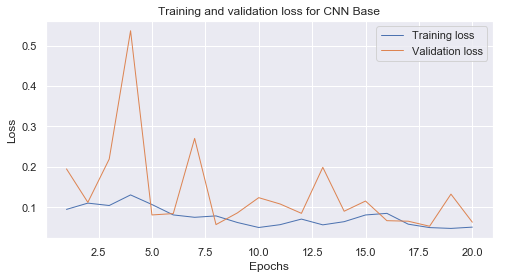

In [271]:
cnn_base_start_time = time.time()
cnn_base_model = rnn_model_generation(CNNBase(32),"CNN Base")
cnn_base_elapsed_time = time.time() - cnn_base_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 64)          1216      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          36928     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 38,209
Trainable params: 38,209
Non-trainable params: 0
_________________________________________________________________


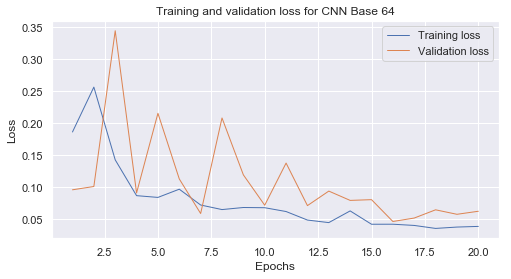

In [272]:
cnn_base64_start_time = time.time()
cnn_base64_model = rnn_model_generation(CNNBase(64),"CNN Base 64")
cnn_base64_elapsed_time = time.time() - cnn_base64_start_time

In [273]:
# table of results
# cnn base
cnn_base_mae = '{:.2}'.format(np.mean(cnn_base_model[2].history['loss']))
cnn_base_val_mae = '{:.2}'.format(np.mean(cnn_base_model[2].history['val_loss']))
# cnn base64
cnn_base64_mae = '{:.2}'.format(np.mean(cnn_base64_model[2].history['loss']))
cnn_base64_val_mae = '{:.2}'.format(np.mean(cnn_base64_model[2].history['val_loss']))

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Train MAE', 'Val MAE', 'Processing Time']
# align fields
a.align["Model"] = "l"
a.align["Layers/Nodes"] = "l"
a.align["Train MAE"] = "l"
a.align["Val MAE"] = "l"
a.align["Processing Time"] = "l"
# add data
a.add_row(['CNN', '32,32', cnn_base_mae, cnn_base_val_mae, round(cnn_base_elapsed_time,1)])
a.add_row(['CNN', '64,64', cnn_base64_mae, cnn_base64_val_mae, round(cnn_base64_elapsed_time,1)])
print(a.get_string(title="CNN Training Results"))

+--------------------------------------------------------------+
|                     CNN Training Results                     |
+-------+--------------+-----------+---------+-----------------+
| Model | Layers/Nodes | Train MAE | Val MAE | Processing Time |
+-------+--------------+-----------+---------+-----------------+
| CNN   | 32,32        | 0.076     | 0.14    | 10.1            |
| CNN   | 64,64        | 0.079     | 0.11    | 11.7            |
+-------+--------------+-----------+---------+-----------------+


## Stacked CNN and RNN Models

In [326]:
def CNNRNNBase(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.Conv1D(node_size1, 9, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(node_size1, 9, activation='relu'))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def CNNRNN2Layers(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.Conv1D(node_size1, 9, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(node_size1, 9, activation='relu'))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def CNNRNN2LayersExtraDense(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.Conv1D(node_size1, 9, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(node_size1, 9, activation='relu'))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(64))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def CNNRNN3Layers(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.Conv1D(node_size1, 9, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(node_size1, 9, activation='relu'))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def CNNRNN3LayersExtraDense(node_size1,node_size2,val1,val2):
    model = Sequential()
    model.add(layers.Conv1D(node_size1, 9, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(node_size1, 9, activation='relu'))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(64))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model

def CNNRNN3LayersExtraDenseLR(node_size1,node_size2,val1,val2,lr):
    model = Sequential()
    model.add(layers.Conv1D(node_size1, 9, activation='relu', input_shape=(None, final_df2.shape[-1])))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(node_size1, 9, activation='relu'))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2, return_sequences=True))
    model.add(layers.LSTM(node_size2, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(64))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(lr=lr), loss='mae')
    return model

In [275]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 18,209
Trainable params: 18,209
Non-trainable params: 0
_________________________________________________________________


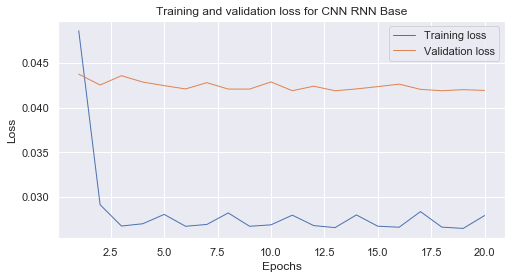

In [276]:
cnnrnn_base_start_time = time.time()
cnnrnn_base_model = rnn_model_generation(CNNRNNBase(32,32,.2,.2),"CNN RNN Base")
cnnrnn_base_elapsed_time = time.time() - cnnrnn_base_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 18,209
Trainable params: 18,209
Non-trainable params: 0
_________________________________________________________________


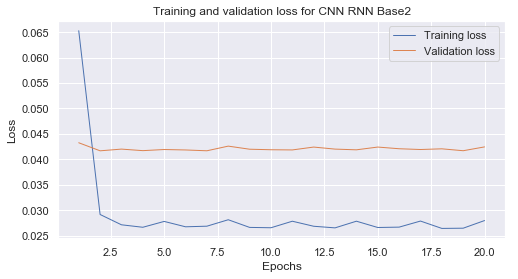

In [277]:
cnnrnn_base_start_time2 = time.time()
cnnrnn_base_model2 = rnn_model_generation(CNNRNNBase(32,32,.1,.5),"CNN RNN Base2")
cnnrnn_base_elapsed_time2 = time.time() - cnnrnn_base_start_time2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 34,753
Trainable params: 34,753
Non-trainable params: 0
_________________________________________________________________


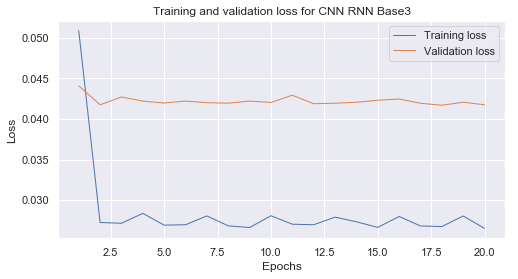

In [278]:
cnnrnn_base_start_time3 = time.time()
cnnrnn_base_model3 = rnn_model_generation(CNNRNNBase(32,64,.2,.2),"CNN RNN Base3")
cnnrnn_base_elapsed_time3 = time.time() - cnnrnn_base_start_time3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 64)          1216      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 64)          36928     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 71,233
Trainable params: 71,233
Non-trainable params: 0
_________________________________________________________________


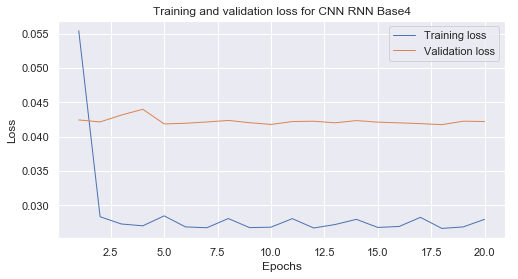

In [279]:
cnnrnn_base_start_time4 = time.time()
cnnrnn_base_model4 = rnn_model_generation(CNNRNNBase(64,64,.2,.2),"CNN RNN Base4")
cnnrnn_base_elapsed_time4 = time.time() - cnnrnn_base_start_time4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 64)          1216      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 64)          36928     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 71,233
Trainable params: 71,233
Non-trainable params: 0
_________________________________________________________________


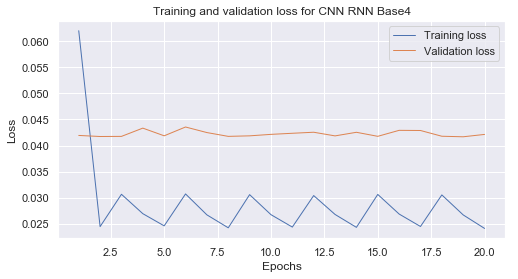

In [280]:
cnnrnn_base_start_time5 = time.time()
cnnrnn_base_model5 = rnn_model_generation(CNNRNNBase(64,64,.1,.5),"CNN RNN Base4")
cnnrnn_base_elapsed_time5 = time.time() - cnnrnn_base_start_time5

In [281]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 67,777
Trainable params: 67,777
Non-trainable params: 0
_________________________________________________________________


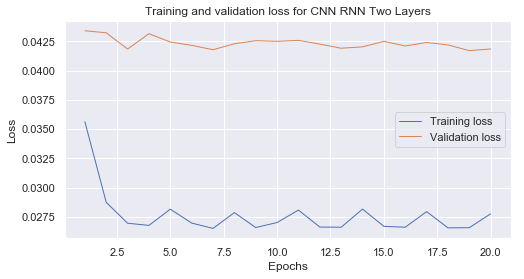

In [282]:
cnnrnn_two_layers_start_time = time.time()
cnnrnn_two_layers_model = rnn_model_generation(CNNRNN2Layers(32,64,.2,.2),"CNN RNN Two Layers")
cnnrnn_two_layers_elapsed_time = time.time() - cnnrnn_two_layers_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total para

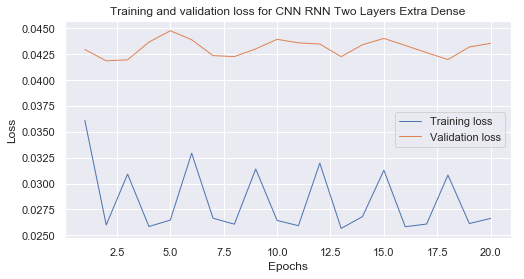

In [283]:
cnnrnn_two_layers_start_time2 = time.time()
cnnrnn_two_layers_model2 = rnn_model_generation(CNNRNN2LayersExtraDense(32,64,.2,.2),"CNN RNN Two Layers Extra Dense")
cnnrnn_two_layers_elapsed_time2 = time.time() - cnnrnn_two_layers_start_time2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total para

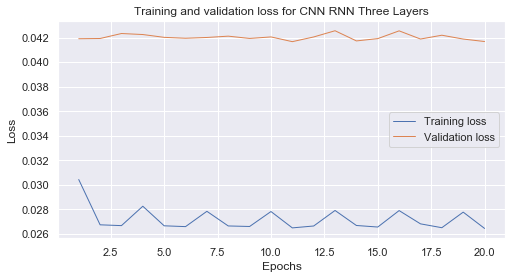

In [284]:
cnnrnn_three_layers_start_time = time.time()
cnnrnn_three_layers_model = rnn_model_generation(CNNRNN3Layers(32,64,.2,.2),"CNN RNN Three Layers")
cnnrnn_three_layers_elapsed_time = time.time() - cnnrnn_three_layers_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
__________

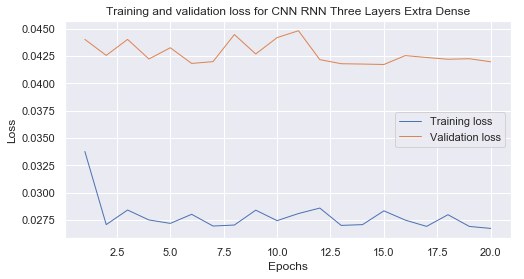

In [285]:
cnnrnn_three_layers_start_time2 = time.time()
cnnrnn_three_layers_model2 = rnn_model_generation(CNNRNN3LayersExtraDense(32,64,.2,.2),"CNN RNN Three Layers Extra Dense")
cnnrnn_three_layers_elapsed_time2 = time.time() - cnnrnn_three_layers_start_time2

In [286]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
__________

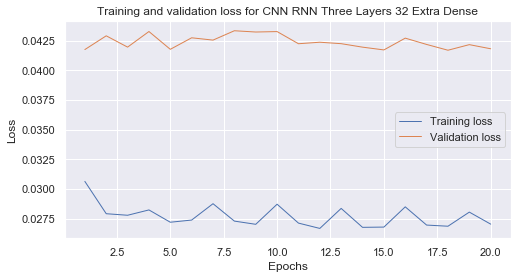

In [324]:
cnnrnn_three_layers_start_time3 = time.time()
cnnrnn_three_layers_model3 = rnn_model_generation(CNNRNN3LayersExtraDense(32,32,.2,.2),"CNN RNN Three Layers 32 Extra Dense")
cnnrnn_three_layers_elapsed_time3 = time.time() - cnnrnn_three_layers_start_time3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          608       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
__________

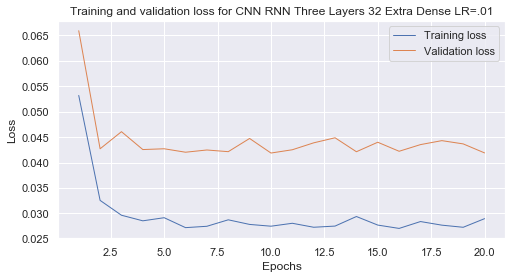

In [327]:
cnnrnn_three_layers_start_time4 = time.time()
cnnrnn_three_layers_model4 = rnn_model_generation(CNNRNN3LayersExtraDenseLR(32,32,.2,.2,.01),"CNN RNN Three Layers 32 Extra Dense LR=.01")
cnnrnn_three_layers_elapsed_time4 = time.time() - cnnrnn_three_layers_start_time4

In [332]:
# table of results
# cnn rnn base
cnnrnn_mae = '{:.2}'.format(np.mean(cnnrnn_base_model[2].history['loss']))
cnnrnn_val_mae = '{:.2}'.format(np.mean(cnnrnn_base_model[2].history['val_loss']))

cnnrnn_mae2 = '{:.2}'.format(np.mean(cnnrnn_base_model2[2].history['loss']))
cnnrnn_val_mae2 = '{:.2}'.format(np.mean(cnnrnn_base_model2[2].history['val_loss']))

cnnrnn_mae3 = '{:.2}'.format(np.mean(cnnrnn_base_model3[2].history['loss']))
cnnrnn_val_mae3 = '{:.2}'.format(np.mean(cnnrnn_base_model3[2].history['val_loss']))

cnnrnn_mae4 = '{:.2}'.format(np.mean(cnnrnn_base_model4[2].history['loss']))
cnnrnn_val_mae4 = '{:.2}'.format(np.mean(cnnrnn_base_model4[2].history['val_loss']))

cnnrnn_mae5 = '{:.2}'.format(np.mean(cnnrnn_base_model5[2].history['loss']))
cnnrnn_val_mae5 = '{:.2}'.format(np.mean(cnnrnn_base_model5[2].history['val_loss']))

# other models
cnnrnn_two_layers_mae = '{:.2}'.format(np.mean(cnnrnn_two_layers_model[2].history['loss']))
cnnrnn_two_layers_val_mae = '{:.2}'.format(np.mean(cnnrnn_two_layers_model[2].history['val_loss']))

cnnrnn_two_layers_mae2 = '{:.2}'.format(np.mean(cnnrnn_two_layers_model2[2].history['loss']))
cnnrnn_two_layers_val_mae2 = '{:.2}'.format(np.mean(cnnrnn_two_layers_model2[2].history['val_loss']))

cnnrnn_three_layers_mae = '{:.2}'.format(np.mean(cnnrnn_three_layers_model[2].history['loss']))
cnnrnn_three_layers_val_mae = '{:.2}'.format(np.mean(cnnrnn_three_layers_model[2].history['val_loss']))

cnnrnn_three_layers_mae2 = '{:.2}'.format(np.mean(cnnrnn_three_layers_model2[2].history['loss']))
cnnrnn_three_layers_val_mae2 = '{:.2}'.format(np.mean(cnnrnn_three_layers_model2[2].history['val_loss']))

cnnrnn_three_layers_mae3 = '{:.2}'.format(np.mean(cnnrnn_three_layers_model3[2].history['loss']))
cnnrnn_three_layers_val_mae3 = '{:.2}'.format(np.mean(cnnrnn_three_layers_model3[2].history['val_loss']))

cnnrnn_three_layers_mae4 = '{:.2}'.format(np.mean(cnnrnn_three_layers_model4[2].history['loss']))
cnnrnn_three_layers_val_mae4 = '{:.2}'.format(np.mean(cnnrnn_three_layers_model4[2].history['val_loss']))

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Train MAE', 'Val MAE', 'Processing Time']
# align fields
a.align["Model"] = "l"
a.align["Layers/Nodes"] = "l"
a.align["Train MAE"] = "l"
a.align["Val MAE"] = "l"
a.align["Processing Time"] = "l"
# add data
a.add_row(['2 CNN/1 RNN', '32,32,32 w/ dropout .2,.2', cnnrnn_mae, cnnrnn_val_mae, round(cnnrnn_base_elapsed_time,1)])
a.add_row(['2 CNN/1 RNN', '32,32,32 w/ dropout .1,.5', cnnrnn_mae2, cnnrnn_val_mae2, round(cnnrnn_base_elapsed_time2,1)])
a.add_row(['2 CNN/1 RNN', '32,32,64 w/ dropout .2,.2', cnnrnn_mae3, cnnrnn_val_mae3, round(cnnrnn_base_elapsed_time3,1)])
a.add_row(['2 CNN/1 RNN', '64,64,64 w/ dropout .2,.2', cnnrnn_mae4, cnnrnn_val_mae4, round(cnnrnn_base_elapsed_time4,1)])
a.add_row(['2 CNN/1 RNN', '64,64,64 w/ dropout .1,.5', cnnrnn_mae5, cnnrnn_val_mae5, round(cnnrnn_base_elapsed_time5,1)])
a.add_row(['2 CNN/2 RNN', '32,32,64,64 w/ dropout .2,.2', cnnrnn_two_layers_mae, cnnrnn_two_layers_val_mae, round(cnnrnn_two_layers_elapsed_time,1)])
a.add_row(['2 CNN/3 RNN', '32,32,64,64,64 w/ dropout .2,.2', cnnrnn_three_layers_mae, cnnrnn_three_layers_val_mae, round(cnnrnn_three_layers_elapsed_time,1)])
a.add_row(['2 CNN/2 RNN Extra Dense', '32,32,64,64 w/ dropout .2,.2', cnnrnn_two_layers_mae2, cnnrnn_two_layers_val_mae2, round(cnnrnn_two_layers_elapsed_time2,1)])
a.add_row(['2 CNN/3 RNN Extra Dense', '32,32,64,64,64 w/ dropout .2,.2', cnnrnn_three_layers_mae2, cnnrnn_three_layers_val_mae2, round(cnnrnn_three_layers_elapsed_time2,1)])
a.add_row(['2 CNN/3 RNN Extra Dense', '32,32,32,32,32 w/ dropout .2,.2', cnnrnn_three_layers_mae3, cnnrnn_three_layers_val_mae3, round(cnnrnn_three_layers_elapsed_time3,1)])
a.add_row(['2 CNN/3 RNN Extra Dense LR=.01', '32,32,32,32,32 w/ dropout .2,.2', cnnrnn_three_layers_mae4, cnnrnn_three_layers_val_mae4, round(cnnrnn_three_layers_elapsed_time4,1)])
print(a.get_string(title="CNN RNN Training Results"))

+----------------------------------------------------------------------------------------------------------+
|                                         CNN RNN Training Results                                         |
+--------------------------------+---------------------------------+-----------+---------+-----------------+
| Model                          | Layers/Nodes                    | Train MAE | Val MAE | Processing Time |
+--------------------------------+---------------------------------+-----------+---------+-----------------+
| 2 CNN/1 RNN                    | 32,32,32 w/ dropout .2,.2       | 0.028     | 0.042   | 24.1            |
| 2 CNN/1 RNN                    | 32,32,32 w/ dropout .1,.5       | 0.029     | 0.042   | 25.4            |
| 2 CNN/1 RNN                    | 32,32,64 w/ dropout .2,.2       | 0.028     | 0.042   | 25.5            |
| 2 CNN/1 RNN                    | 64,64,64 w/ dropout .2,.2       | 0.029     | 0.042   | 29.5            |
| 2 CNN/1 RNN      

# Results

In [349]:
# evaluate best models on the test set
# these take some time to generate

# rnn model
rnn_best_model = load_model('RNN 3 Layers Dropout2.h5')
rnn_best_results = rnn_best_model.evaluate_generator(test_gen, steps=test_steps)
rnn_best_predictions = rnn_best_model.predict_generator(test_gen, steps=test_steps)

rnn_best_model2 = load_model('RNN 3 Layers 64 Dense.h5')
rnn_best_results2 = rnn_best_model2.evaluate_generator(test_gen, steps=test_steps)
rnn_best_predictions2 = rnn_best_model2.predict_generator(test_gen, steps=test_steps)

rnn_best_model3 = load_model('RNN 3 Layers 32 Dropout 64 Dense LR=.01.h5')
rnn_best_results3 = rnn_best_model3.evaluate_generator(test_gen, steps=test_steps)
rnn_best_predictions3 = rnn_best_model3.predict_generator(test_gen, steps=test_steps)

# cnn model
cnn_best_model = load_model('CNN Base 64.h5')
cnn_best_results = cnn_best_model.evaluate_generator(test_gen, steps=test_steps)
cnn_best_predictions = cnn_best_model.predict_generator(test_gen, steps=test_steps)

# cnn rnn model
cnnrnn_best_model = load_model('CNN RNN Base.h5')
cnnrnn_best_results = cnnrnn_best_model.evaluate_generator(test_gen, steps=test_steps)
cnnrnn_best_predictions = cnnrnn_best_model.predict_generator(test_gen, steps=test_steps)

# ensembled models
ensembled_results = .2 * (cnn_best_results + rnn_best_results3 + rnn_best_results2 + rnn_best_results + cnnrnn_best_results)
ensembled_results2 = .33 * (rnn_best_results2 + rnn_best_results + cnnrnn_best_results)
ensembled_results3 = .5 * (rnn_best_results2 + cnnrnn_best_results)

ensembled_preds = .2 * (cnn_best_predictions + rnn_best_predictions3 + rnn_best_predictions2 + rnn_best_predictions + cnnrnn_best_predictions)
ensembled_preds2 = .33 * (rnn_best_predictions2 + rnn_best_predictions + cnnrnn_best_predictions)
ensembled_preds3 = .5 * (rnn_best_predictions2 + cnnrnn_best_predictions)

In [352]:
# generate table to summarize results
rnn_best_mae = '{:.3}'.format(rnn_best_results)
rnn_best_mae2 = '{:.3}'.format(rnn_best_results2)
rnn_best_mae3 = '{:.3}'.format(rnn_best_results3)
cnn_best_mae = '{:.3}'.format(cnn_best_results)
cnnrnn_best_mae = '{:.3}'.format(cnnrnn_best_results)
ensembled_mae = '{:.3}'.format(ensembled_results)
ensembled_mae2 = '{:.3}'.format(ensembled_results2)
ensembled_mae3 = '{:.3}'.format(ensembled_results3)

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'MAE']
# align fields
a.align["Model"] = "l"
a.align["Layers/Nodes"] = "l"
a.align["MAE"] = "l"
a.add_row(['RNN', '32,32,32 dropout .1,.5', rnn_best_mae])
a.add_row(['RNN Extra Dense 64', '32,32,32 dropout .2,.2', rnn_best_mae2])
a.add_row(['RNN Extra Dense 64 LR=.01', '32,32,32 dropout .2,.2', rnn_best_mae3])
a.add_row(['CNN','64,64', cnn_best_mae])
a.add_row(['2 CNN/1 RNN ', '32,32,32 w/ dropout .2,.2', cnnrnn_best_mae])
a.add_row(['Ensemble - All Models', '', ensembled_mae])
a.add_row(['Ensemble - No CNN', '', ensembled_mae2])
a.add_row(['Ensemble - RNN/CNN RNN', '', ensembled_mae3])
print(a.get_string(title="Test Set Results"))

+------------------------------------------------------------------+
|                         Test Set Results                         |
+---------------------------+---------------------------+----------+
| Model                     | Layers/Nodes              | MAE      |
+---------------------------+---------------------------+----------+
| RNN                       | 32,32,32 dropout .1,.5    | 0.000288 |
| RNN Extra Dense 64        | 32,32,32 dropout .2,.2    | 0.000169 |
| RNN Extra Dense 64 LR=.01 | 32,32,32 dropout .2,.2    | 0.00412  |
| CNN                       | 64,64                     | 0.0256   |
| 2 CNN/1 RNN               | 32,32,32 w/ dropout .2,.2 | 0.000284 |
| Ensemble - All Models     |                           | 0.00609  |
| Ensemble - No CNN         |                           | 0.000245 |
| Ensemble - RNN/CNN RNN    |                           | 0.000227 |
+---------------------------+---------------------------+----------+


# Appendix

## Five Layers

In [494]:
def RNN5LayersWithDropout(node_size,val1,val2):
    model = Sequential()
    model.add(layers.LSTM(node_size, return_sequences=True, dropout=val1, recurrent_dropout=val2, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.LSTM(node_size, return_sequences=True, dropout=val1, recurrent_dropout=val2))
    model.add(layers.LSTM(node_size, return_sequences=True, dropout=val1, recurrent_dropout=val2))
    model.add(layers.LSTM(node_size, return_sequences=True, dropout=val1, recurrent_dropout=val2))
    model.add(layers.LSTM(node_size, dropout=val1, recurrent_dropout=val2))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mae')
    return model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_53 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_54 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_55 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_56 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 33        
Total params: 37,793
Trainable params: 37,793
Non-trainable params: 0
_________________________________________________________________


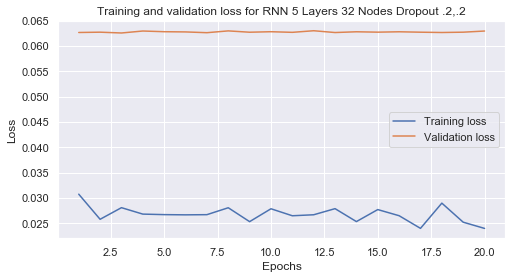

In [495]:
rnn_five_layers_dropout32_start_time = time.time()
rnn_five_layers_dropout32_model = rnn_model_generation(RNN5LayersWithDropout(32,.2,.2),"RNN 5 Layers 32 Nodes Dropout .2,.2")
rnn_five_layers_dropout32_elapsed_time = time.time() - rnn_five_layers_dropout32_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, None, 32)          4480      
_________________________________________________________________
lstm_58 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_59 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_60 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_61 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 33        
Total params: 37,793
Trainable params: 37,793
Non-trainable params: 0
_________________________________________________________________


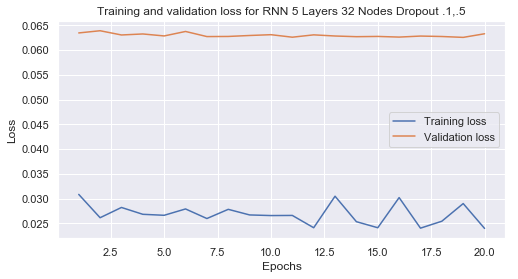

In [496]:
rnn_five_layers_dropout32_start_time2 = time.time()
rnn_five_layers_dropout32_model2 = rnn_model_generation(RNN5LayersWithDropout(32,.1,.5),"RNN 5 Layers 32 Nodes Dropout .1,.5")
rnn_five_layers_dropout32_elapsed_time2 = time.time() - rnn_five_layers_dropout32_start_time2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, None, 64)          17152     
_________________________________________________________________
lstm_63 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_64 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_65 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_66 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 65        
Total params: 149,313
Trainable params: 149,313
Non-trainable params: 0
_________________________________________________________________


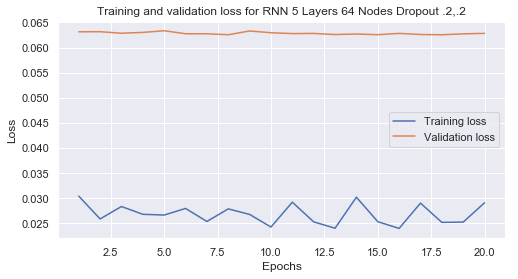

In [497]:
rnn_five_layers_dropout64_start_time = time.time()
rnn_five_layers_dropout64_model = rnn_model_generation(RNN5LayersWithDropout(64,.2,.2),"RNN 5 Layers 64 Nodes Dropout .2,.2")
rnn_five_layers_dropout64_elapsed_time = time.time() - rnn_five_layers_dropout64_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, None, 64)          17152     
_________________________________________________________________
lstm_68 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_69 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_70 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_71 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 65        
Total params: 149,313
Trainable params: 149,313
Non-trainable params: 0
_________________________________________________________________


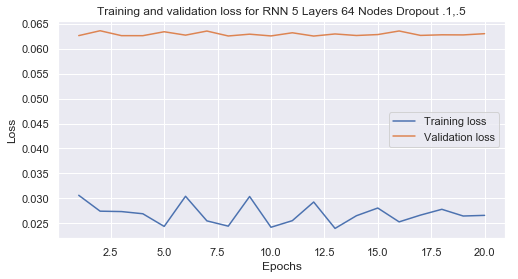

In [498]:
rnn_five_layers_dropout64_start_time2 = time.time()
rnn_five_layers_dropout64_model2 = rnn_model_generation(RNN5LayersWithDropout(64,.1,.5),"RNN 5 Layers 64 Nodes Dropout .1,.5")
rnn_five_layers_dropout64_elapsed_time2 = time.time() - rnn_five_layers_dropout64_start_time2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, None, 128)         67072     
_________________________________________________________________
lstm_73 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_74 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_75 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_76 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 129       
Total params: 593,537
Trainable params: 593,537
Non-trainable params: 0
_________________________________________________________________


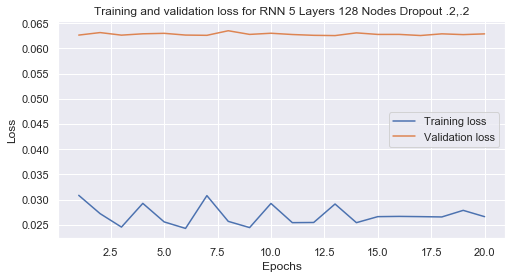

In [499]:
rnn_five_layers_dropout128_start_time = time.time()
rnn_five_layers_dropout128_model = rnn_model_generation(RNN5LayersWithDropout(128,.2,.2),"RNN 5 Layers 128 Nodes Dropout .2,.2")
rnn_five_layers_dropout128_elapsed_time = time.time() - rnn_five_layers_dropout128_start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, None, 128)         67072     
_________________________________________________________________
lstm_78 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_79 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_80 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_81 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 129       
Total params: 593,537
Trainable params: 593,537
Non-trainable params: 0
_________________________________________________________________


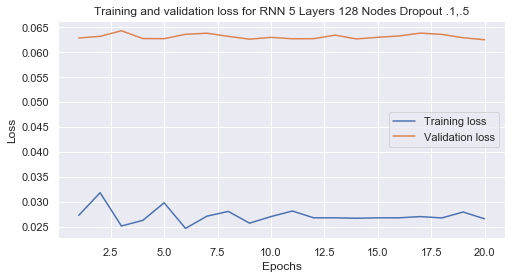

In [500]:
rnn_five_layers_dropout128_start_time2 = time.time()
rnn_five_layers_dropout128_model2 = rnn_model_generation(RNN5LayersWithDropout(128,.1,.5),"RNN 5 Layers 128 Nodes Dropout .1,.5")
rnn_five_layers_dropout128_elapsed_time2 = time.time() - rnn_five_layers_dropout128_start_time2

## Using Hyperparameter Optimization

In [ ]:
# Keras + Hyperopt: A very simple wrapper for convenient hyperparameter optimization 
# {{choice([32, 64, 128])}}
# Hyperas seems very finnicky....not sure if there is a different route to take
# didn't spend a ton of time here

In [465]:
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, LSTM, Flatten, Dense, SimpleRNN, Dropout
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim

def data():
    return train_gen, val_gen

def create_model(train_gen, val_gen):
    model = Sequential()
    model.add(layers.LSTM(32, input_shape=(None, final_df2.shape[-1])))
    model.add(layers.Dense(1))
    model.compile(optimizer={{choice(['RMSprop', 'Adam'])}}, loss='mae')
    history = model.fit_generator(train_gen,steps_per_epoch=steps,epochs=num_epochs,validation_data=val_gen,validation_steps=val_steps,verbose=0)
    validation_loss = np.amin(history.history['val_loss']) 
    print('Best validation MAE of epoch:', validation_loss)
    return {'loss': validation_loss, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run = optim.minimize(model=create_model,algo=tpe.suggest,data=data,max_evals=10,trials=Trials(),notebook_name='JRodd Assignment 4')